# Classifying Basketball Positions

This notebook builds and evaluates a Pytorch classification model to classify player positions in mens college basketball teams. The data is webscrapped from https://www.sports-reference.com/cbb/.

**Importantly**, the webscrapped data is commented out because it is very time intensive. For ease of use, import the Player Stats csv and adjust the filepath as necessary.
Player stats is missing webscrapped teams in 2021: New Orleanss, Brown, Columbia, Cornell, Dartmouth, Harvard, Pennsylvania, Princeton, and Yale. Player stats is also missing St. Francis (NY) Terriers in 2024.

**Furthermore**, hyperparameter tuning may take between 30-40 min if re-running the code.

# 0: Creating Webscrapped CSV

## Import Libraries & Modules


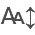

In [4]:
import requests
import time
import pandas as pd
from bs4 import BeautifulSoup
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

## Setup Global Variables

In [6]:
earliest_season = 2005
latest_season = 2025

## Webscraping

### This code block webscrapes the school ids that will be used when extracting the team rosters
url = 'https://www.sports-reference.com/cbb/schools/'
headers = {'User-Agent': 'Mozilla/5.0'}
max_retries = 5
initial_delay = 15  # seconds
for attempt in range(max_retries):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 429:
            print(f"429 Too Many Requests. Retrying in {initial_delay} seconds...")
            time.sleep(initial_delay)
            initial_delay *= 2  # Exponential backoff
            continue # Retry with longer delay
        response.raise_for_status()  # Raise other HTTP errors
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id='NCAAM_schools')
        if table:
            break # Success: move onto extracting data
        else:
            print("Table not found. The structure might have changed.")
            break
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        time.sleep(initial_delay)
else:
    print("Max retries reached. Exiting...")
headers = [th.get_text(strip=True) for th in table.find_all('thead')[0].find_all('th')]
rows = []
for row in table.find('tbody').find_all('tr'):
    if row.get('class') == ['thead']:
        continue
    data = [cell.get_text(strip=True) for cell in row.find_all(['th', 'td'])]
    if data:
        rows.append(data)
schools_df = pd.DataFrame(rows, columns=headers)
### Map the difference between school index and html url
exceptions_map = {
    "Alabama A&M": "alabama-am",
    "Albany (NY)": "albany-ny",
    "Allegheny Gators": "allegheny",
    "Amherst Lord Jeffs": "amherst",
    "Armstrong Pirates": "armstrong",
    "Augusta Jaguars": "augusta-state",
    "Augustana (IL) Vikings": "augusta-il",
    "Baldwin-Wallace Yellow Jackets": "baldwin-wallace",
    "Baltimore Super Bees": "baltimore",
    "Beloit Buccaneers": "beloit",
    "Birmingham-Southern Panthers": "birmingham-southern",
    "Bloomsburg Huskies": "bloomsburg",
    "Brooklyn Bulldogs": "brooklyn",
    "Cal State Los Angeles Golden Eagles": "cal-state-los-angeles",
    "Canterbury College": "central-normal-college",  
    "Carleton College Knights": "carleton-college",
    "Carnegie Mellon Tartans": "carnegie-",
    "Case Western Reserve Spartans": "case-western-reserve",
    "Catholic Cardinals": "catholic",
    "Centenary (LA) Gents": "centenary-la",
    "Central Missouri Mules": "central-missouri",
    "Central Pennsylvania College Knights": "central-pennsylvania-college",
    "Centre (KY) Colonels": "centre-ky",
    "Chicago Maroons": "chicago",
    "City College of New York Beavers": "city-college-of-new-york",
    "College of New Jersey Lions": "college-of-new-jersey",
    "Colorado College Tigers": "colorado-college",
    "Colorado School of Mines Orediggers": "colorado-school-of-mines",
    "Concordia Seminary Preachers": "concordia-seminary",
    "Cotner College": "cotner-university",
    "Dakota Wesleyan Tigers": "dakota-wesleyan",
    "Denison Big Red": "denison",
    "DePauw Tigers": "depauw",
    "Dickinson College Red Devils": "dickinson-college",
    "East Central Tigers": "east-central",
    "East Texas A&M": "texas-am-commerce",
    "Emporia State Hornets": "emporia-state",
    "Ensign College": "latter-day-saints-university",
    "FDU": "fairleigh-dickinson",
    "Florida A&M": "florida-am",
    "Franklin Grizzlies": "franklin",
    "Geneva Golden Tornadoes": "geneva",
    "Gettysburg Bullets": "gettysburg",
    "Grinnell Pioneers": "grinnell",
    "Grove City Wolverines": "grove-city",
    "Hamline Pipers": "hamline",
    "Hardin-Simmons Cowboys": "hardin-simmons",
    "Hartford Hawks": "hartford",
    "Haskell (KS) Fighting Indians": "haskell-indian-nations-institute",
    "Hiram Terriers": "hiram",
    "Hope Flying Dutchmen": "hope",
    "Houston Christian": "houston-baptist",
    "Illinois Wesleyan Titans": "illinois-wesleyan",
    "IU Indy": "iupui",
    "John Carroll Blue Streaks": "john-carroll",
    "Kalamazoo Hornets": "kalamazoo",
    "Kansas City": "missouri-kansas-city",
    "Kentucky Wesleyan Panthers": "kentucky-wesleyan",
    "Lake Forest Foresters": "lake-forest",
    "Lewis Flyers": "lewis",
    "Little Rock": "arkansas-little-rock",
    "Louisiana": "louisiana-lafayette",
    "Loyola (IL)": "loyola-il",
    "Loyola (LA) Wolfpack": "loyola-la",
    "Loyola (MD)": "loyola-md",
    "Macalester Scots": "macalester",
    "Manchester Spartans": "manchester",
    "Marietta Pioneers": "marietta",
    "Massachusetts Institute of Technology Engineers": "massachusetts-institute-of-technology",  
    "Merchant Marine Mariners": "merchant-marine-academy",
    "Miami (FL)": "miami-fl",
    "Miami (OH)": "miami-oh",
    "Millikin Big Blue": "millikin",
    "Millsaps Majors": "millsaps",
    "Minnesota A&M Aggies": "minnesota-am",
    "Morris Brown Wolverines": "morris-brown",
    "Mount St. Mary's": "mount-st-marys",
    "Mount Union Purple Raiders": "mount-union",
    "Muhlenberg Mules": "muhlenberg",
    "Muskingum Fighting Muskies": "muskingum",
    "NC State": "north-carolina-state",
    "Nebraska Wesleyan Prairie Wolves": "nebraska-wesleyan",
    "New York University Violets": "new-york-university",
    "Newberry Wolves": "newberry",
    "North Carolina A&T": "north-carolina-at",
    "North Central (IL) Cardinals": "north-central",
    "Northeastern Illinois Golden Eagles": "northeastern-illinois",
    "Northwest Missouri State Bearcats": "northwest-missouri-state",
    "Oberlin Yeomen": "oberlin",
    "Ohio Wesleyan Battling Bishops": "ohio-wesleyan",
    "Oklahoma City Chiefs": "oaklahoma-city",
    "Omaha": "nebraska-omaha",
    "Phillips Haymakers": "phillips",  
    "Pittsburg State Gorillas": "pittsburg-state",
    "Pratt Institute Cannoneers": "pratt-institute",
    "Purdue Fort Wayne": "ipfw",
    "Queens (NC)": "queens-nc",
    "Regis (CO) Rangers": "regis-co",
    "Rensselaer Engineers": "rensselaer",  
    "Ripon Red Hawks": "ripon",
    "Roanoke Maroons": "roanoke",
    "Rochester (NY) Yellowjackets": "rochester-ny",
    "Rose-Hulman Fightin' Engineers": "rose-hulman",  
    "Saint Francis (PA)": "saint-francis-pa",
    "Saint Joseph's": "saint-josephs",
    "Saint Mary's (CA)": "saint-marys-ca",
    "Saint Peter's": "saint-peters",
    "Sam Houston": "sam-houston-state",
    "Savannah State Tigers": "savannah-state",
    "Scranton Royals": "scranton",
    "Sewanee Tigers": "sewanee",
    "Southwestern (KS) Moundbuilders": "southwestern-ks",
    "Southwestern (TX) Pirates": "southwestern-tx",
    "Springfield Pride": "springfield",
    "St. Bonaventure": "st-bonaventure",
    "St. Francis (NY) Terriers": "st-francis-ny",
    "St. John's (NY)": "st-johns-ny",
    "St. John's College (OH)": "st-johns-college-oh",
    "St. Lawrence Saints": "st-lawrence",
    "St. Thomas": "st-thomas-mn",
    "Stephen F. Austin": "stephen-f-austin",
    "Stevens Institute Ducks": "stevens-institute",
    "SUNY-Potsdam Bears": "suny-potsdam",
    "Swarthmore Garnet": "swarthmore",
    "TCU": "texas-christian",
    "Texas A&M": "texas-am",
    "Texas A&M-Corpus Christi": "texas-am-corpus-christi",
    "Texas Wesleyan Rams": "texas-wesleyan",
    "Texas-Rio Grande Valley": "texas-pan-american",
    "The Citadel": "citadel",
    "Trinity (CT) Bantams": "trinity-ct",
    "Trinity (TX) Tigers": "trinity-tx",
    "U.S. International Gulls": "alliant-international",
    "UAB": "alabama-birmingham",
    "UC Davis": "california-davis",
    "UC Irvine": "california-irvine",
    "UC Riverside": "california-riverside",
    "UC San Diego": "california-san-diego",
    "UC Santa Barbara": "california-santa-barbara",
    "UCF": "central-florida",
    "UNC Asheville": "north-carolina-asheville",
    "UNC Greensboro": "north-carolina-greensboro",
    "UNC Wilmington": "north-carolina-wilmington",
    "Union (NY) Dutchmen": "union-ny",
    "UT Arlington": "texas-arlington",
    "Utah Tech": "dixie-state",
    "UTEP": "texas-el-paso",
    "Utica Pioneers": "utica",
    "UTSA": "texas-san-antonio",
    "Wabash Little Giants": "wabash",
    "Washburn Ichabods": "washburn",
    "Washington & Jefferson Presidents": "washington-jefferson",
    "Washington & Lee Generals": "washington-lee",
    "Washington (MO) Bears": "washington-mo",
    "Washington College Shoremen": "washington-college",
    "Wayne State (MI) Warriors": "wayne-state-mi",
    "Wesleyan (CT) Cardinals": "wesleyan-ct",
    "West Chester Golden Rams": "west-chester",
    "West Texas A&M Buffaloes": "west-texas-am",
    "Western Colorado Mountaineers": "western-state",
    "Westminster (MO) Blue Jays": "westminster-mo",
    "Westminster (PA) Titans": "westminster-pa",
    "Wheaton (IL) Thunder": "wheaton-il",
    "Whittier Poets": "whittier",
    "Widener Pride": "widener",
    "William & Mary": "william-mary",
    "Williams Ephs": "williams",
    "Wisconsin-Stevens Point Pointers": "wisconsin-stevens-point",
    "Wisconsin-Superior Yellowjackets": "wisconsin-superior",
    "Wittenberg Tigers": "wittenberg",
    "Wooster Fighting Scots": "wooster",
    "WPI Engineers": "worcester-tech"
}
schools_df['School'] = schools_df['School'].replace(exceptions_map)
schools_df['To'] = schools_df['To'].astype('int32')
schools_df = schools_df[schools_df['To'] > (earliest_season - 1)].reset_index() # Teams must exist in the intended time period
schools_df = schools_df['School']
schools_df = schools_df.str.replace(' ', '-').str.lower()  # Must be lowercase to work in html url
schools_df

### This code block webscrapes the team rosters using the school ids from the previous code block
### This is very time intensive; each year takes 2-2.5 hours to fully capture all possible teams
player_stats = pd.DataFrame()
max_retries = 10
initial_delay = 5  # seconds
for year in range(earliest_season, latest_season+1):
    print(year) # Show the progress of code
    for school in schools_df:
        url = f"https://www.sports-reference.com/cbb/schools/{school}/men/{year}.html"
        retries = 0
        delay = initial_delay
        while retries < max_retries:
            try:
                headers = {'User-Agent': 'Mozilla/5.0'}
                response = requests.get(url, headers=headers, timeout=10)
                if response.status_code == 429:
                    time.sleep(delay)
                    delay *= 2  # Exponential backoff
                    retries += 1
                    continue # Retry with longer delay
                if response.status_code != 200:
                    break  # Move to the next school; failed to retrieve data
                soup = BeautifulSoup(response.content, 'html.parser')
                table = soup.find('table', id='players_per_game')
                if table is None:
                    print(f"No data found for {school} in {year}.")
                    break  # Move to the next school
                headers = [th.get_text(strip=True) for th in table.find('thead').find_all('th')]
                rows = []
                for row in table.find('tbody').find_all('tr'):
                    if row.get('class') == ['thead']:
                        continue
                    data = [cell.get_text(strip=True) for cell in row.find_all(['th', 'td'])]
                    if data:
                        rows.append(data)
                df = pd.DataFrame(rows, columns=headers)
                drop = ['Rk', 'Awards', 'G']
                df = df.drop(columns=[col for col in drop if col in df.columns], errors='ignore')
                # df.fillna(0, inplace=True)
                # numeric_cols = [col for col in df.columns if col != 'Player']
                # df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce').astype('float16')
                df['Season'] = int(year)
                df['School'] = school
                player_stats = pd.concat([player_stats, df], ignore_index=True)  # Rolling merge of data across schools and years
                break  # Move to the next school
            except requests.RequestException as e:
                print(f"Error for {school}: {e}")
                time.sleep(initial_delay)
                break
player_stats
### Considering this is an intensive webscrape, it is best to save as csv and import rather than webscrape whenever the kernel is restarted
player_stats.to_csv("C:/Users/mouct/Downloads/Player_Stats.csv", index=False)  # Adjust CSV file path

# 1: Setup Environment

## Apply Libraries, Modules, and Global Variables


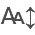

In [12]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

In [13]:
SEED = 24
earliest_season = 2005
latest_season = 2025
BATCH_SIZE = 32
learning_rate = 0.001
EPOCHS = 20
Tuning_EPOCHS = EPOCHS//2

## Read Webscrapped CSV

In [15]:
player_stats = pd.read_csv("C:/Users/mouct/Downloads/Player_Stats.csv")  # Adjust filepath
player_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99899 entries, 0 to 99898
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  99899 non-null  object 
 1   Pos     99471 non-null  object 
 2   GS      99787 non-null  float64
 3   MP      99699 non-null  float64
 4   FG      99872 non-null  float64
 5   FGA     99872 non-null  float64
 6   FG%     97011 non-null  float64
 7   3P      99872 non-null  float64
 8   3PA     99872 non-null  float64
 9   3P%     80684 non-null  float64
 10  2P      99872 non-null  float64
 11  2PA     99872 non-null  float64
 12  2P%     94737 non-null  float64
 13  eFG%    97011 non-null  float64
 14  FT      99872 non-null  float64
 15  FTA     99872 non-null  float64
 16  FT%     89280 non-null  float64
 17  ORB     98364 non-null  float64
 18  DRB     98364 non-null  float64
 19  TRB     99872 non-null  float64
 20  AST     99872 non-null  float64
 21  STL     99872 non-null  float64
 22

In [16]:
player_stats.dropna(inplace=True)
player_stats = player_stats[player_stats['Pos'] != 'G-F']  # Only want to examine centers, forwards, and guards
print(player_stats.info())
player_stats.reset_index(drop=True, inplace=True)
player_stats

<class 'pandas.core.frame.DataFrame'>
Index: 73715 entries, 0 to 99897
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  73715 non-null  object 
 1   Pos     73715 non-null  object 
 2   GS      73715 non-null  float64
 3   MP      73715 non-null  float64
 4   FG      73715 non-null  float64
 5   FGA     73715 non-null  float64
 6   FG%     73715 non-null  float64
 7   3P      73715 non-null  float64
 8   3PA     73715 non-null  float64
 9   3P%     73715 non-null  float64
 10  2P      73715 non-null  float64
 11  2PA     73715 non-null  float64
 12  2P%     73715 non-null  float64
 13  eFG%    73715 non-null  float64
 14  FT      73715 non-null  float64
 15  FTA     73715 non-null  float64
 16  FT%     73715 non-null  float64
 17  ORB     73715 non-null  float64
 18  DRB     73715 non-null  float64
 19  TRB     73715 non-null  float64
 20  AST     73715 non-null  float64
 21  STL     73715 non-null  float64
 22  BLK

Player Pos    GS    MP   FG   FGA    FG%   3P  3PA    3P%  \
0            Antoine Hood   G  30.0  33.7  4.8  10.3  0.464  1.3  3.9  0.342   
1              Nick Welch   C  30.0  30.9  4.1   9.0  0.461  1.5  3.9  0.397   
2             Matt McCraw   G  18.0  25.9  2.8   5.6  0.509  1.8  3.6  0.509   
3          Jacob Burtschi   F  30.0  27.3  3.0   6.4  0.474  1.0  3.5  0.298   
4            Dan Nwaelele   F  12.0  21.9  2.7   6.0  0.456  1.2  2.8  0.426   
...                   ...  ..   ...   ...  ...   ...    ...  ...  ...    ...   
73710          Gabe Dynes   C   7.0  21.8  2.9   4.2  0.699  0.0  0.1  0.000   
73711     Siem Uijtendaal   G   6.0  16.3  1.1   3.1  0.366  0.8  2.1  0.391   
73712     David Wilkerson   G   0.0   7.7  1.1   2.8  0.408  0.3  1.1  0.276   
73713         Nik Hendrix   G   0.0   3.0  0.8   1.8  0.444  0.2  1.0  0.200   
73714  Christian Kirkland   F   0.0   8.1  0.7   1.2  0.571  0.0  0.0  0.000   

       ...  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  Season            School  
0      ...  1.9  3.1  1.9  1.3  0.1  1.8  2.4  13.0    2005         air-force  
1      ...  2.5  3.6  3.0  1.3  0.5  2.3  2.3  12.0    2005         air-force  
2      ...  1.4  1.7  1.8  1.1  0.1  1.0  1.5   9.0    2005         air-force  
3      ...  3.0  4.3  1.1  1.6  0.1  0.8  2.3   8.0    2005         air-force  
4      ...  1.5  2.3  1.3  0.8  0.1  1.3  1.7   7.6    2005         air-force  
...    ...  ...  ...  ...  ...  ...  ...  ...   ...     ...               ...  
73710  ...  3.3  5.8  0.4  0.3  3.1  1.2  2.5   6.8    2025  youngstown-state  
73711  ...  1.3  2.0  1.0  0.6  0.2  0.9  1.5   3.5    2025  youngstown-state  
73712  ...  0.9  1.3  0.8  0.3  0.0  0.7  1.1   3.0    2025  youngstown-state  
73713  ...  0.0  0.0  0.0  0.0  0.2  0.0  0.0   2.2    2025  youngstown-state  
73714  ...  1.2  1.9  0.1  0.3  0.5  0.3  1.5   1.8    2025  youngstown-state  

[73715 rows x 28 columns]

# Data Dictionary

| Column | Variable | Data type | Description |
|:-----:|:----------|:-----------|:-------------|
| 0 | Player | object | Individual player on the team | 
| 1 | Pos | object | Position (G: Guard, C: Center, F: Forward) |
| 2 | GS | int64 | Number of Games where the player was in the starting lineup |
| 3 | MP | float64 | Average number of minutes played per game |
| 4 | FG | float64 | Average number of successful field goals per game |
| 5 | FGA | float64 | Average number of field goals attempted per game |
| 6 | FG%  | float64 | Percent average successful field goals per game  |
| 7 | 3P | float64 | Average number of successful 3-point field goals per game |
| 8 | 3PA | float64 | Average number of 3-point field goals attempted per game |
| 9 | 3P% | float64 | Percent average successful 3-point field goals per game |
| 10 | 2P | float64 | Average number of successful 2-point field goals per game |
| 11 | 2PA | float64 | Average number of 2-point field goals attempted per game |
| 12 | 2P% | float64 | Percent average successful 2-point field goals per game |
| 13 | eFG% | float64 | Effective Field Goal Percentage: Percent average successful field goals per game (weighting 3-point field goals more) |
| 14 | FT | float64 | Average number of successful free throws per game |
| 15 | FTA | float64 | Average number of free throws attempted per game |
| 16 | FT% | float64 | Percent average successful free throws per game |
| 17 | ORB | float64 | Average number of offensive rebounds per game |
| 18 | DRB | float64 | Average number of defensive rebounds per game |
| 19 | TRB | float64 | Average number of total rebounds per game |
| 20 | TRB | float64 | Average number of assists per game |
| 21 | STL | float64 | Average number of steals per game |
| 22 | BLK | float64 | Average number of blocks per game |
| 23 | TOV | float64 | Average number of turnovers per game |
| 24 | PF | float64 | Average number of personal fouls per game |
| 25 | PTS | float64 | Average number of points scored per game |
| 26 | Season | int64 | Basketball Season (Represents the year March Madness happens) |
| 27 | School | object | School name |

# 2: EDA

In [20]:
guards = player_stats[player_stats['Pos'] == 'G']
forwards = player_stats[player_stats['Pos'] == 'F']
centers = player_stats[player_stats['Pos'] == 'C']
custom_ticks = [2005, 2008, 2010, 2013, 2015, 2018, 2020, 2023, 2025]  # Used in subsequent line charts

In [21]:
def histograms(df):
    ''' Creates a histogram plot for each variable'''
    j = 0
    fig, ax = plt.subplots(12, 2, figsize=(18,30))
    ax = ax.ravel()
    exclude = ['Player', 'Pos', 'Season', 'School']
    for i in [c for c in df.columns if c not in exclude]:
        sns.histplot(data=df[i], kde=True, ax=ax[j])
        ax[j].set_title(f'Distribution of {i}')
        j += 1
    plt.tight_layout()
    plt.show()

In [22]:
def median_plot(df):
    ''' Creates a line plot of the median values for each variable'''
    j = 0
    fig, ax = plt.subplots(12, 2, figsize=(15,30))
    ax = ax.ravel()
    exclude = ['Player', 'Pos', 'Season', 'School']
    for i in [c for c in df.columns if c not in exclude]:
        sns.lineplot(data=df.groupby('Season')[i].median(), ax=ax[j])
        ax[j].set_xticks(custom_ticks)
        ax[j].set_title(f'Median {i} by Season')
        j += 1
    plt.tight_layout()
    plt.show()

In [23]:
# These variables should be usfeul in analyzing position characteristics
key_variables = ['FG', 'FGA', '2P', '2PA', '3P', '3PA', 'ORB', 'DRB', 'STL', 'TOV', 'PTS']
for i in key_variables:
    print(f"{i}\n{player_stats.groupby('Pos')[i].describe()}\n")

FG
       count      mean       std  min  25%  50%  75%   max
Pos                                                       
C     2432.0  2.399794  1.709666  0.0  1.0  2.0  3.6   8.6
F    24575.0  2.478942  1.683596  0.0  1.1  2.2  3.6  10.8
G    46708.0  2.457800  1.691177  0.0  1.0  2.2  3.6   9.8

FGA
       count      mean       std  min  25%  50%  75%   max
Pos                                                       
C     2432.0  4.738651  3.117796  0.2  2.1  4.1  6.9  15.9
F    24575.0  5.315609  3.358165  0.1  2.5  4.7  7.6  22.2
G    46708.0  5.995495  3.824052  0.1  2.8  5.5  8.7  22.2

2P
       count      mean       std  min  25%  50%  75%   max
Pos                                                       
C     2432.0  2.229153  1.650798  0.0  0.8  1.8  3.3   8.6
F    24575.0  2.011772  1.535603  0.0  0.8  1.6  3.0  10.1
G    46708.0  1.533097  1.243139  0.0  0.5  1.2  2.3   8.4

2PA
       count      mean       std  min  25%  50%  75%   max
Pos                                    

## Proportion of Positions over Time

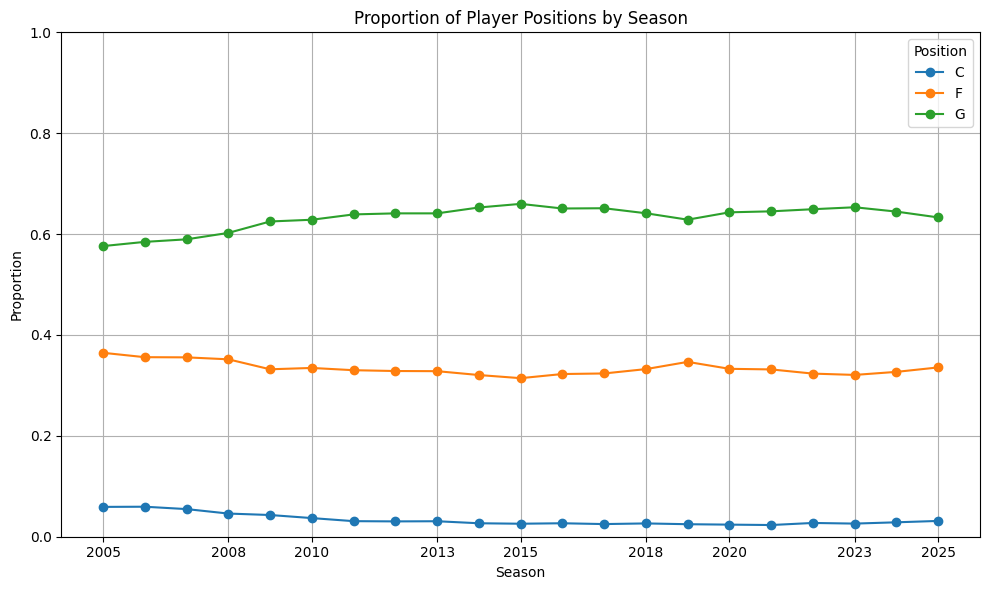

In [25]:
position_distribution = (
    player_stats.groupby('Season')['Pos']
    .value_counts(normalize=True)
    .unstack()  # Converts 'Pos' values to columns: G, F, C
)
position_distribution.plot(kind='line', marker='o', figsize=(10,6))
plt.xticks(custom_ticks)
plt.title('Proportion of Player Positions by Season')
plt.xlabel('Season')
plt.ylabel('Proportion')
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title='Position')
plt.tight_layout()
plt.show()

In [26]:
print(player_stats.groupby('Season')['Pos'].value_counts(normalize=True).to_string())

Season  Pos
2005    G      0.576211
        F      0.364641
        C      0.059149
2006    G      0.584566
        F      0.355949
        C      0.059486
2007    G      0.589614
        F      0.355605
        C      0.054782
2008    G      0.602343
        F      0.351726
        C      0.045931
2009    G      0.625000
        F      0.331952
        C      0.043048
2010    G      0.628436
        F      0.334614
        C      0.036949
2011    G      0.639005
        F      0.330138
        C      0.030857
2012    G      0.641095
        F      0.328520
        C      0.030385
2013    G      0.641086
        F      0.328217
        C      0.030697
2014    G      0.652742
        F      0.320569
        C      0.026690
2015    G      0.659891
        F      0.314343
        C      0.025766
2016    G      0.650745
        F      0.322563
        C      0.026693
2017    G      0.651253
        F      0.323677
        C      0.025070
2018    G      0.641307
        F      0.332326
    

## Guards

### Histogram Summary

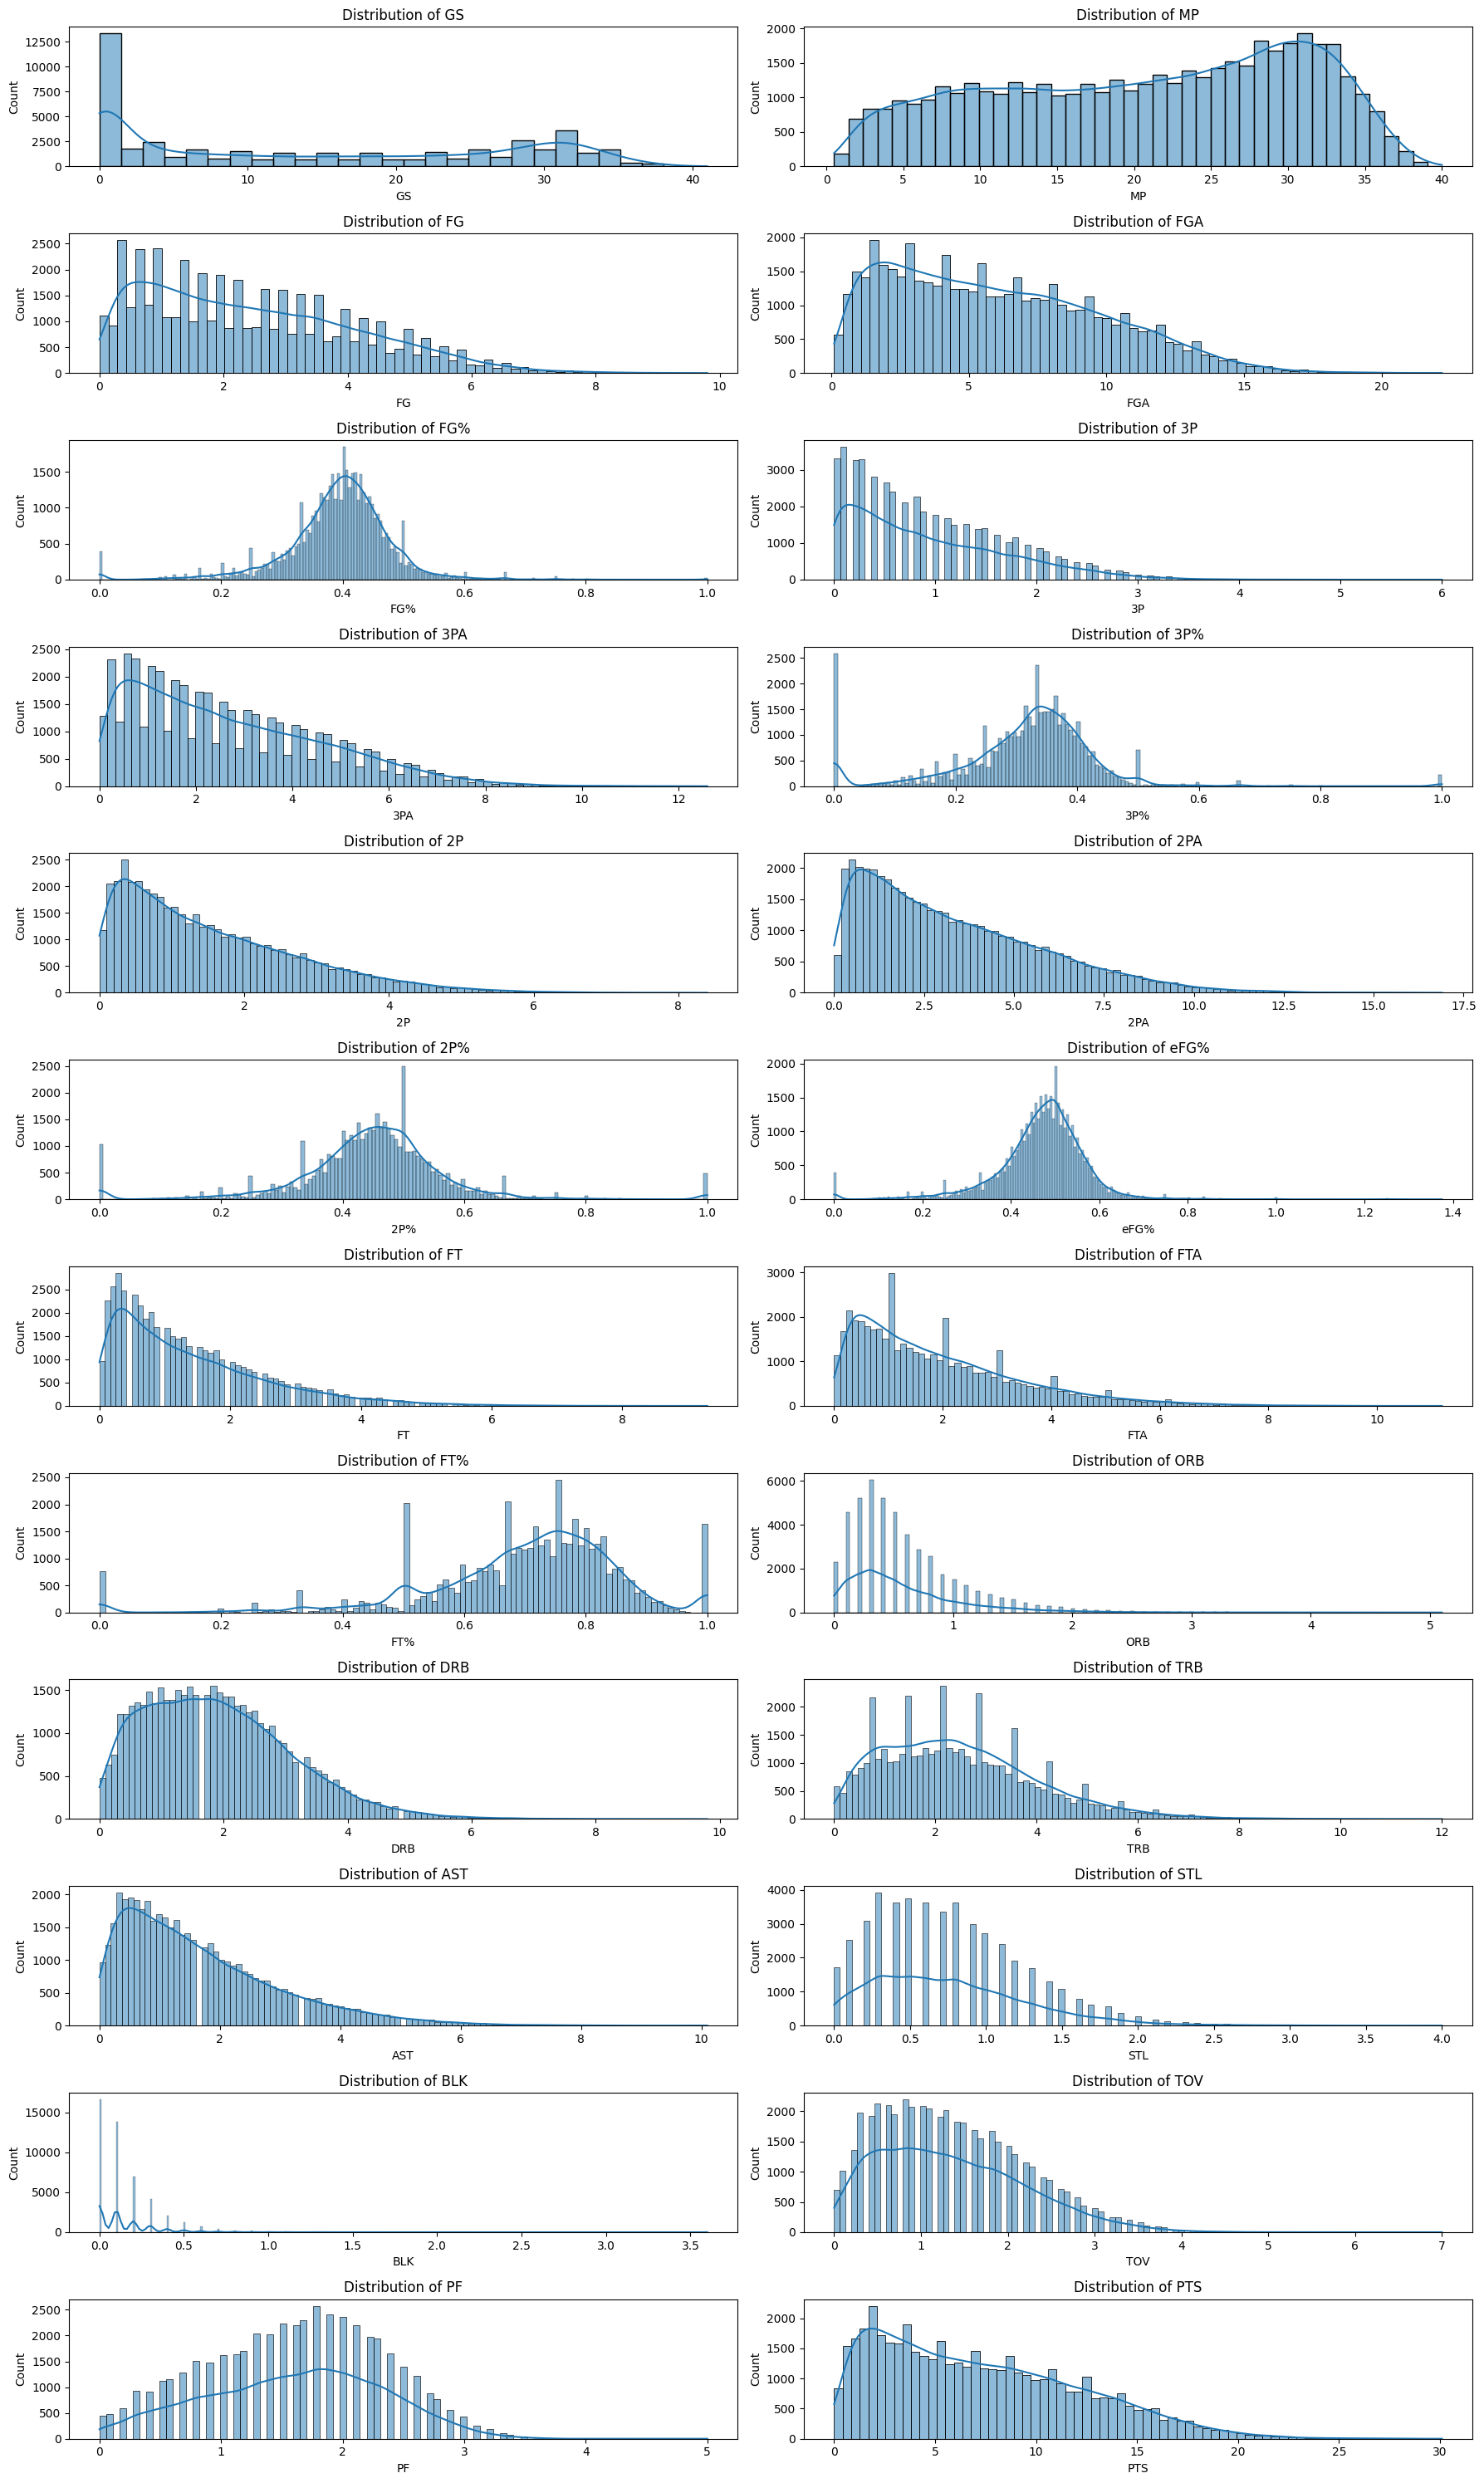

In [29]:
histograms(guards)

### Median Over Time

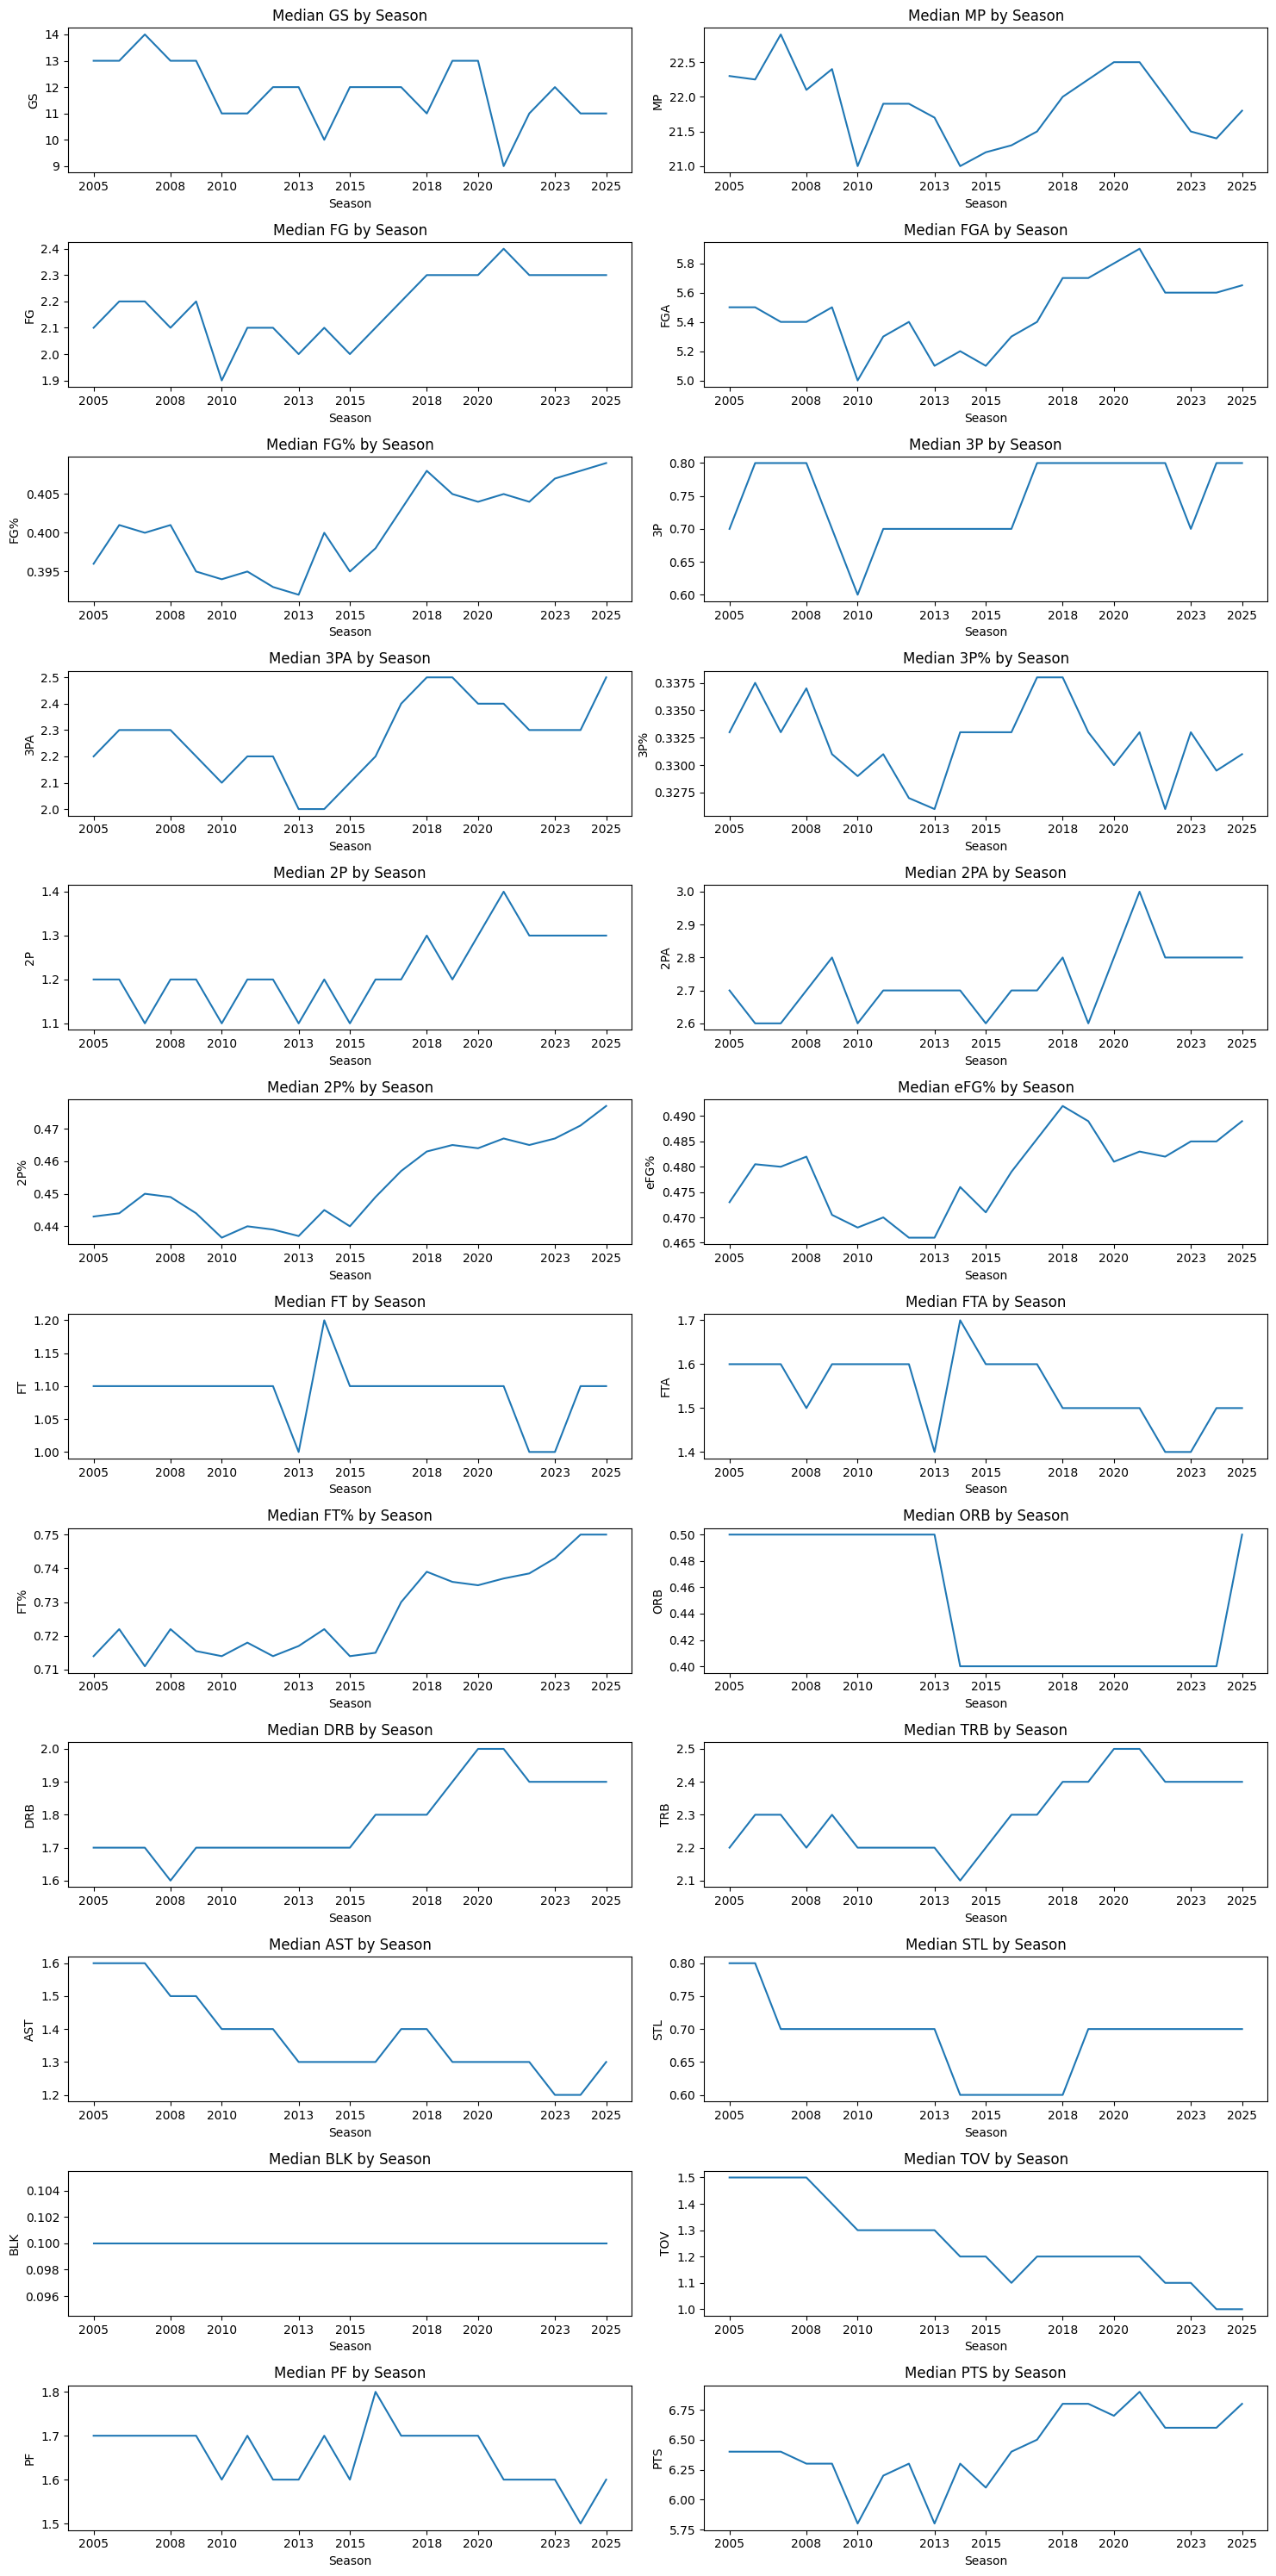

In [31]:
median_plot(guards)

## Centers

### Histogram Summary

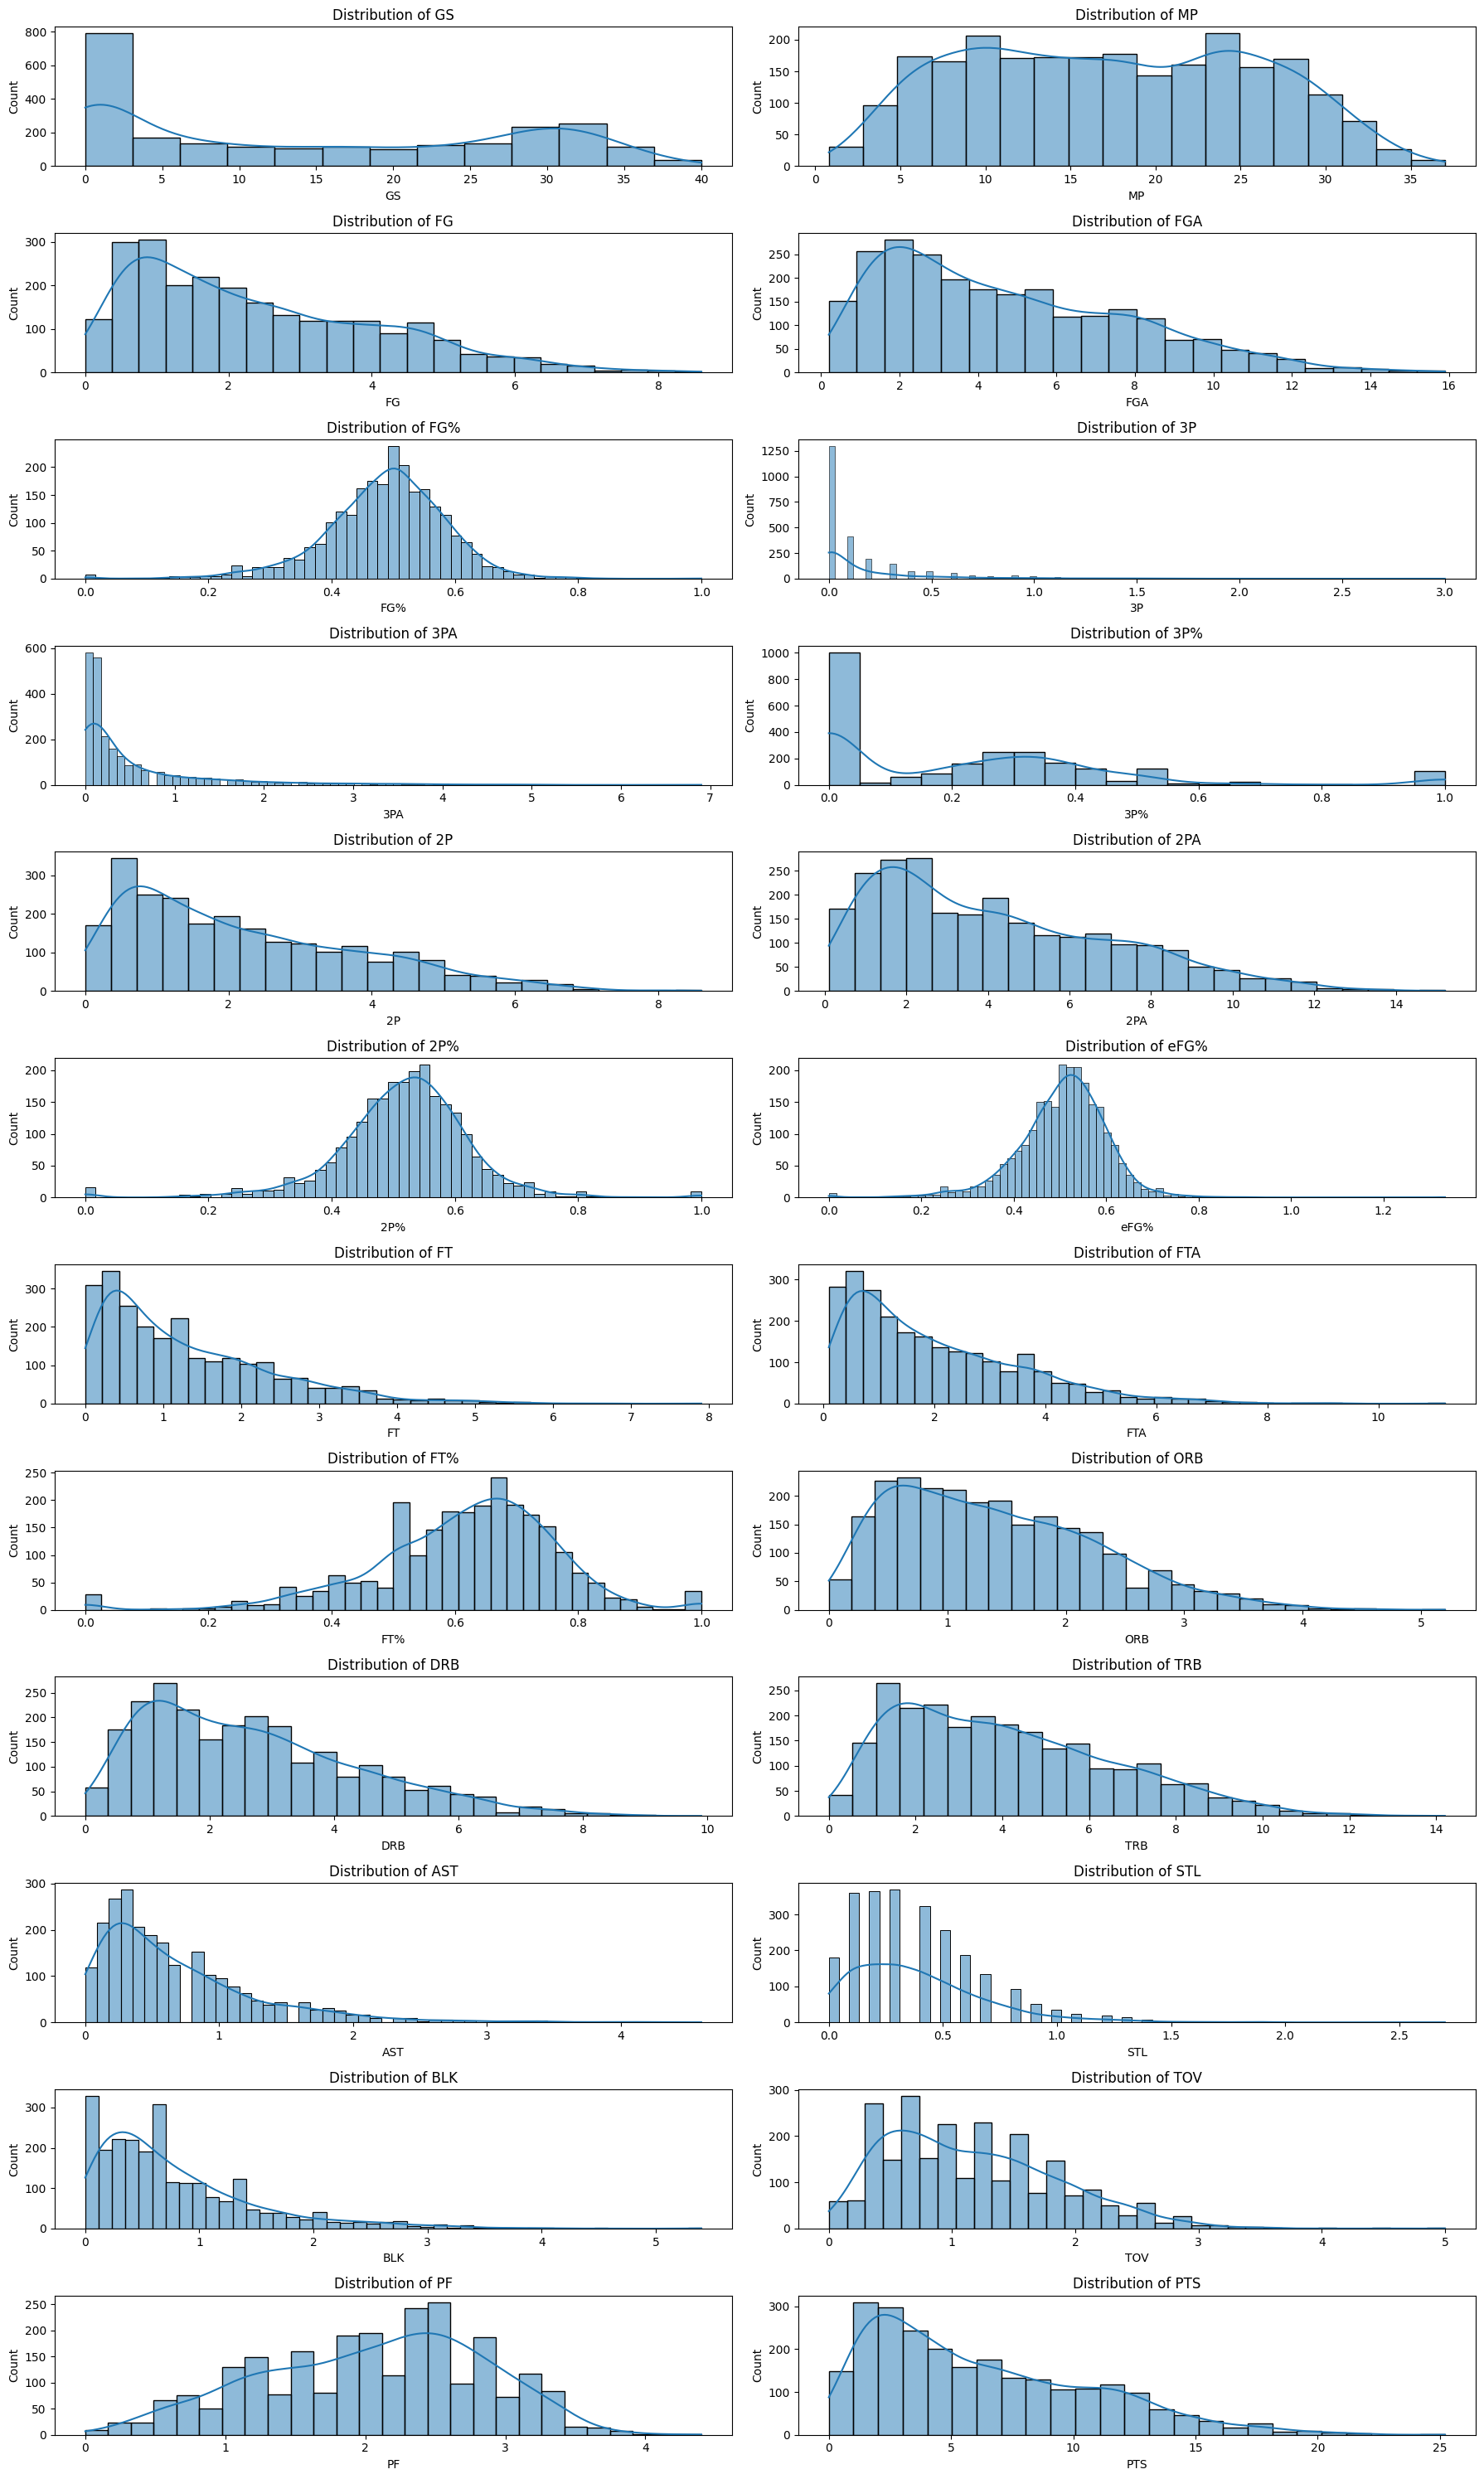

In [34]:
histograms(centers)

### Median Over Time

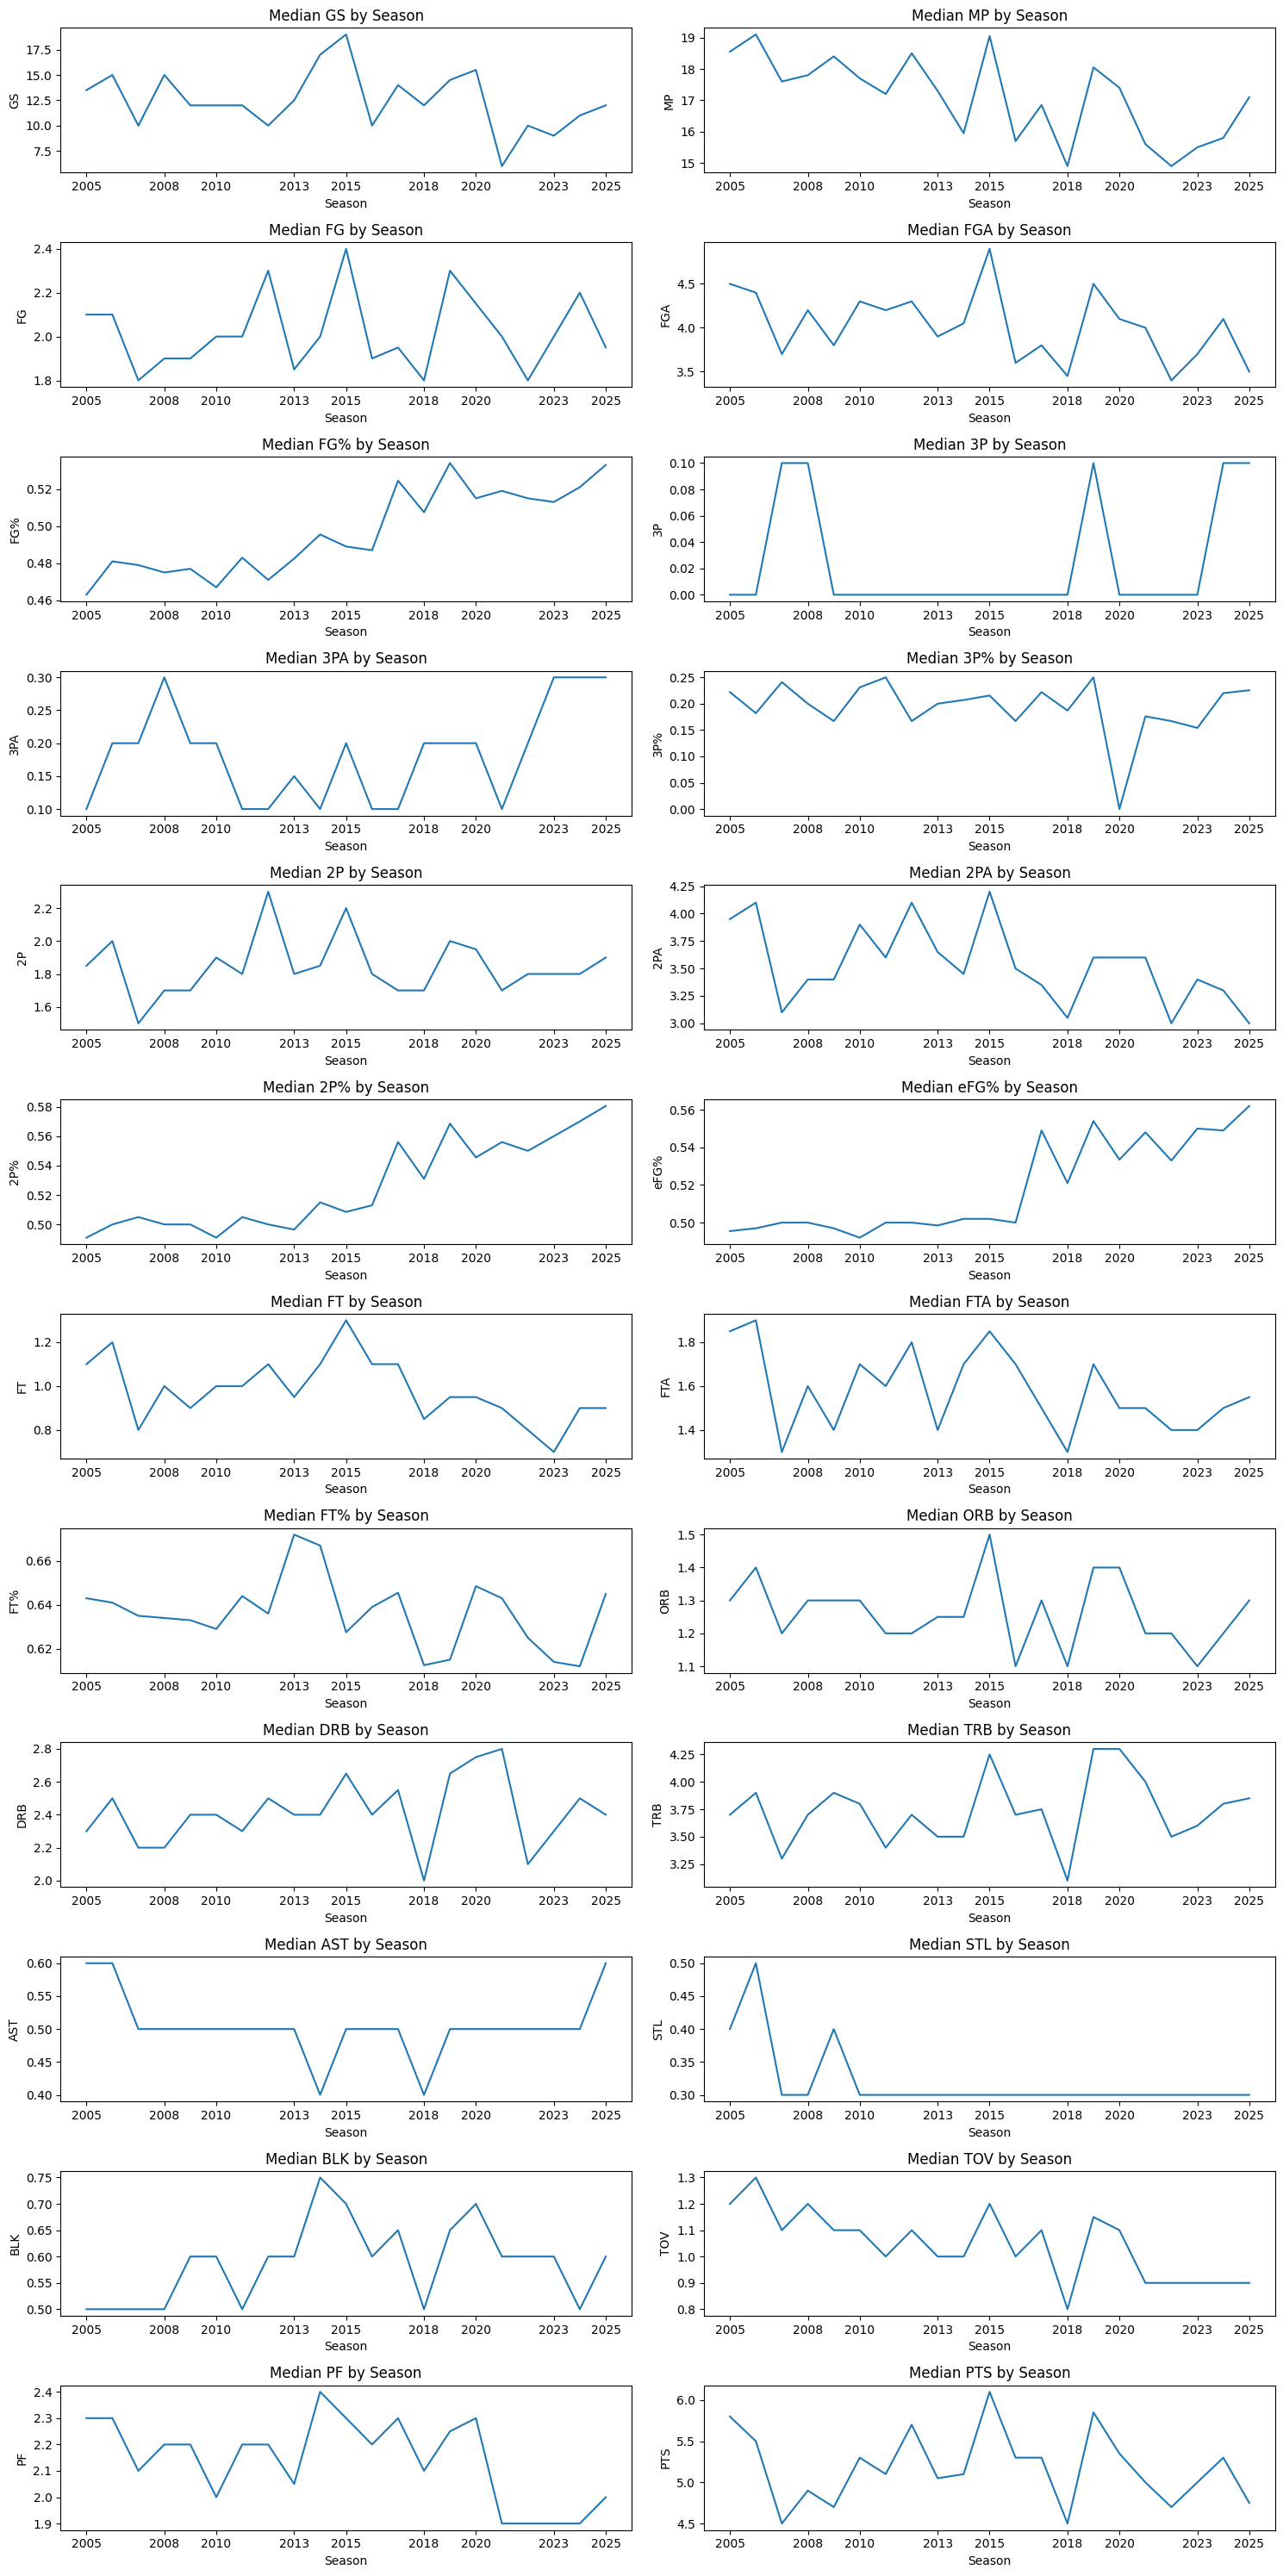

In [36]:
median_plot(centers)

## Forwards

### Histogram Summary

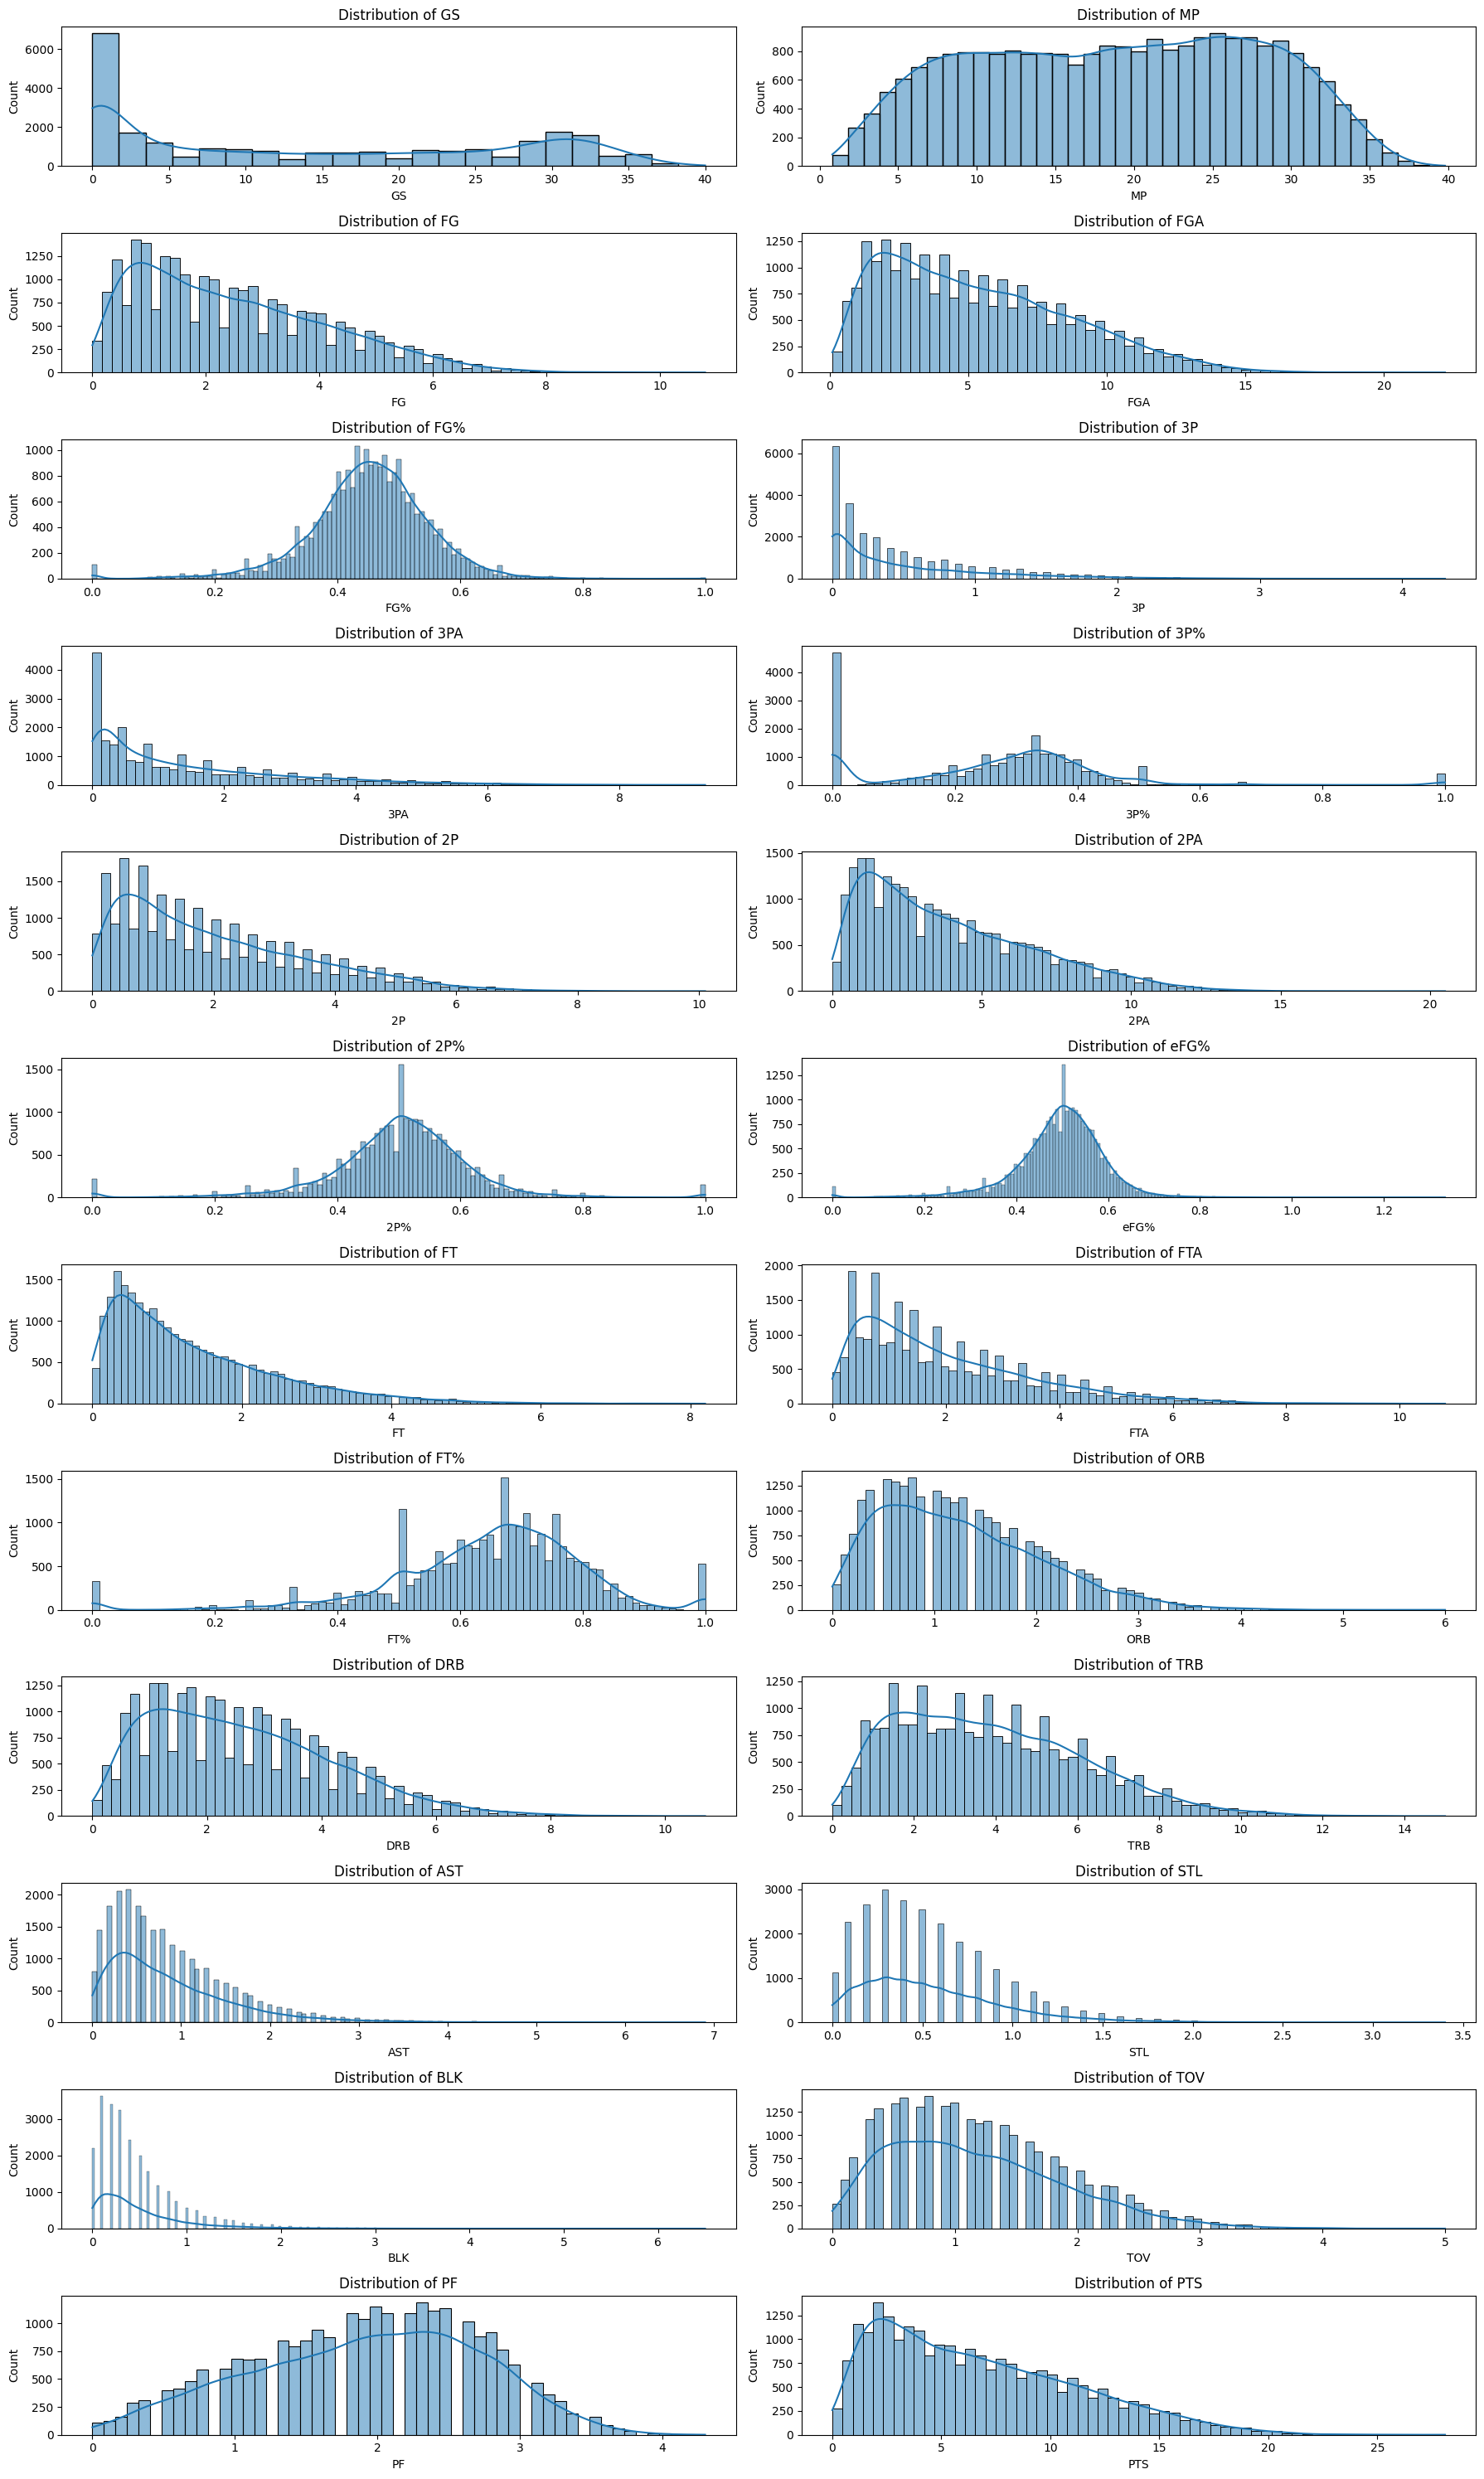

In [39]:
histograms(forwards)

### Median Over Time

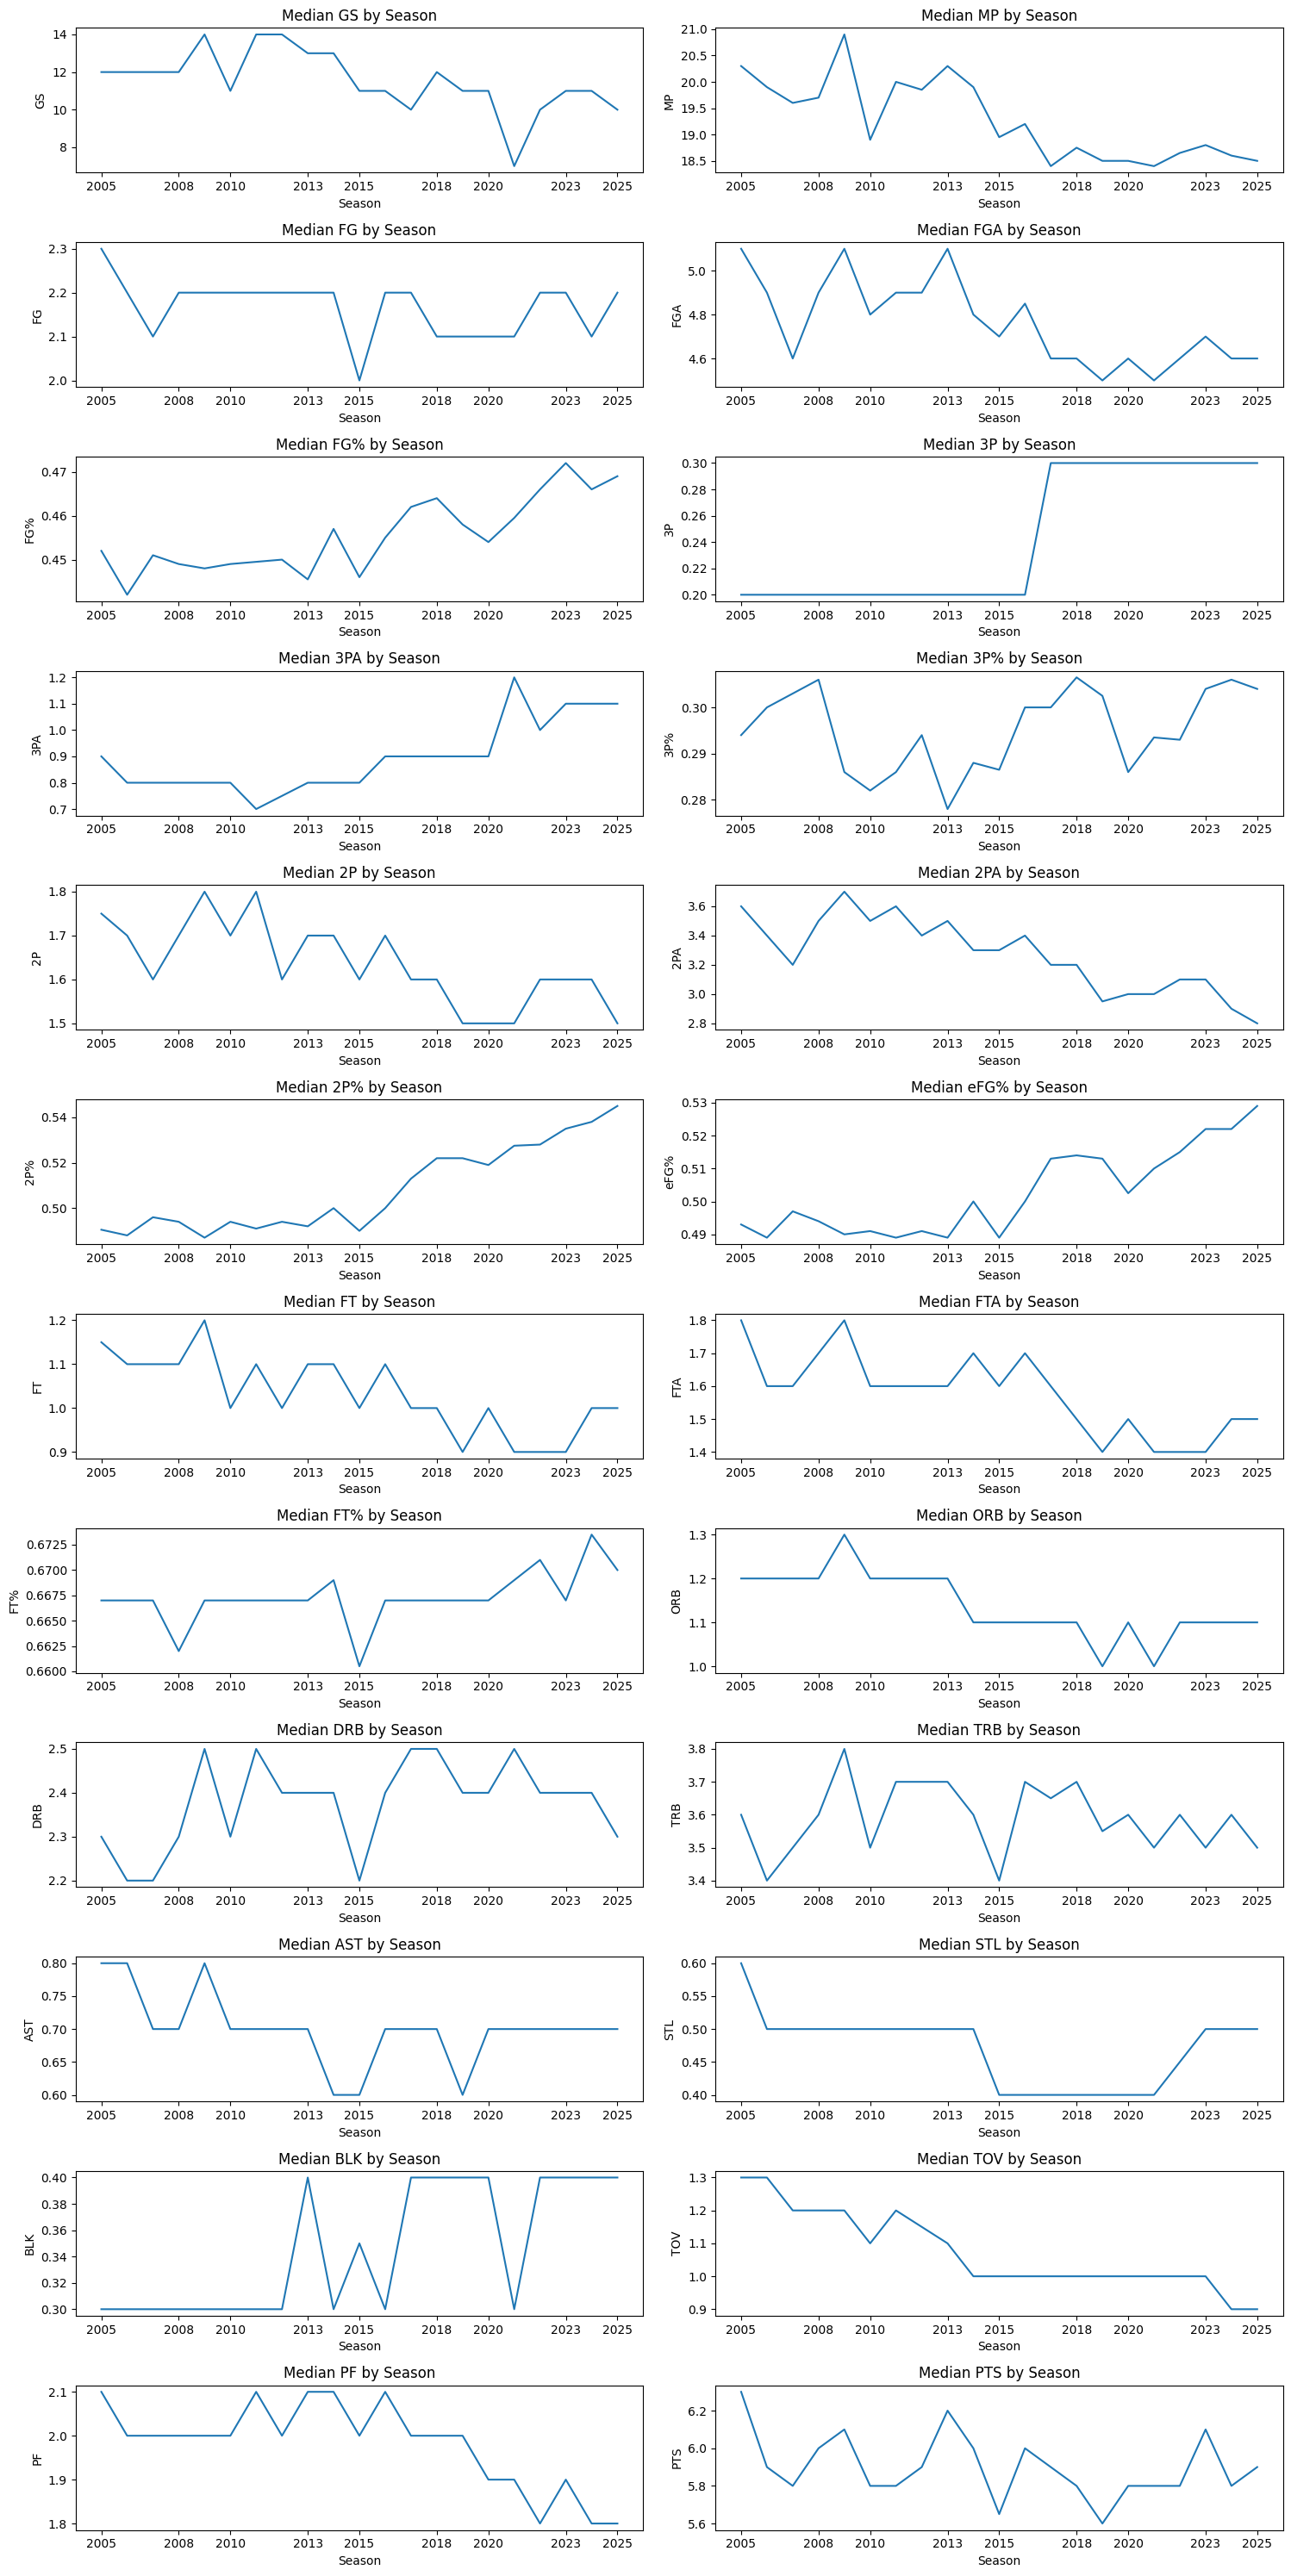

In [41]:
median_plot(forwards)

## EDA Analysis

The first observation is the difference in sample size of Centers, Forwards, and Guards. It is shocking to me that only 3% of sampled players (across all mens college basketball teams over 20 years) are classified as Centers. Just as shocking is the fact that close to 2/3 of the players sampled are classified as Guards (almost double the number of Forwards). Given that a basketball lineup consists of 5 players, the expectation would be a 40/40/20 split in distribution between guards, forwards, and centers respectively. My hypothesis is that overall basketball strategy is favoring 3-point field goals (often the strength of guard positions). As such, more and more of the roster is comprised of guards, then forwards, and then there is far less emphasis to have more than 1 Center on the team. To investigate this hypothesis, I initiated 2 analyses.

First, I examined the different performance metrics across the 3 positions. Guards showcased far greater means for 3P, 3PA, and STL than the other positions (50% of Centers never even had a successful 3P). This is in-line with the convention of guards being the offensive leaders and playing outside the 3-point line. Centers showcased greater means for 2P, 2PA, and ORB. This is in-line with the convention of centers being the defensive leaders and protecting the basket as the last line of defense.

Second, I examined the position proportions from 2005-2025. In 2005, 57% of players in that season were Guards. This proportion grew to 64% by 2012 and has hovered around that range ever since. Clearly, guards have always dominated the basketball roster so it isn't fair to say that this is a dramatic shift. However, the share of guard players grew predominantly at the expense of centers. Considering centers lead in 2P and 2PA, I do think this change is reflective of a push to a 3P-centric strategy across teams. 

The other substantial observation is that most of the histograms across the 3 positions are right-skewed (FG, FGA, 3P, 3PA, 2P, 2PA, etc.). My hypothesis for this phenomenon is that on average, no individual player in a rooster is given the opportunity to "dominate" or be "star players". Each player is able to contribute to steals, rebounds, and field goals all while trying to overcome the defense of the opposing team. Players will pass to whichever player is most capable of scoring.

# 3: Preparing Classification Model

In [45]:
player_stats.drop(columns=['GS','Player','School','Season','MP'],inplace=True)
assert len(player_stats['Pos'].unique()) == 3
player_stats = player_stats[player_stats['Pos'].isin(['F', 'G', 'C'])]
player_stats

Pos   FG   FGA    FG%   3P  3PA    3P%   2P  2PA    2P%  ...    FT%  \
0       G  4.8  10.3  0.464  1.3  3.9  0.342  3.4  6.4  0.539  ...  0.788   
1       C  4.1   9.0  0.461  1.5  3.9  0.397  2.6  5.1  0.510  ...  0.667   
2       G  2.8   5.6  0.509  1.8  3.6  0.509  1.0  2.0  0.508  ...  0.898   
3       F  3.0   6.4  0.474  1.0  3.5  0.298  2.0  2.9  0.682  ...  0.703   
4       F  2.7   6.0  0.456  1.2  2.8  0.426  1.5  3.2  0.483  ...  0.818   
...    ..  ...   ...    ...  ...  ...    ...  ...  ...    ...  ...    ...   
73710   C  2.9   4.2  0.699  0.0  0.1  0.000  2.9  4.1  0.709  ...  0.478   
73711   G  1.1   3.1  0.366  0.8  2.1  0.391  0.3  1.0  0.313  ...  0.619   
73712   G  1.1   2.8  0.408  0.3  1.1  0.276  0.9  1.7  0.489  ...  0.667   
73713   G  0.8   1.8  0.444  0.2  1.0  0.200  0.6  0.8  0.750  ...  1.000   
73714   F  0.7   1.2  0.571  0.0  0.0  0.000  0.7  1.2  0.588  ...  0.481   

       ORB  DRB  TRB  AST  STL  BLK  TOV   PF   PTS  
0      1.3  1.9  3.1  1.9  1.3  0.1  1.8  2.4  13.0  
1      1.1  2.5  3.6  3.0  1.3  0.5  2.3  2.3  12.0  
2      0.3  1.4  1.7  1.8  1.1  0.1  1.0  1.5   9.0  
3      1.2  3.0  4.3  1.1  1.6  0.1  0.8  2.3   8.0  
4      0.8  1.5  2.3  1.3  0.8  0.1  1.3  1.7   7.6  
...    ...  ...  ...  ...  ...  ...  ...  ...   ...  
73710  2.5  3.3  5.8  0.4  0.3  3.1  1.2  2.5   6.8  
73711  0.7  1.3  2.0  1.0  0.6  0.2  0.9  1.5   3.5  
73712  0.4  0.9  1.3  0.8  0.3  0.0  0.7  1.1   3.0  
73713  0.0  0.0  0.0  0.0  0.0  0.2  0.0  0.0   2.2  
73714  0.7  1.2  1.9  0.1  0.3  0.5  0.3  1.5   1.8  

[73715 rows x 23 columns]

In [46]:
# Resampling 'C' to ensure the model is ensure enough samples for proper training 
df_majority = player_stats[player_stats['Pos'] != 'C']
df_minority = player_stats[player_stats['Pos'] == 'C']
df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority) // 2,  # Match half the size of other positions
    random_state=SEED
)
resampled_player_stats = pd.concat([df_majority, df_minority_upsampled]).reset_index()

## Train-Test-Validation Split

In [48]:
train = resampled_player_stats.sample(frac=0.7, random_state = SEED)
test = resampled_player_stats.drop(train.index)
val = test.sample(frac=0.5, random_state=SEED)  # Validation useful to tune hyperparameters and avoid overfitting
test = test.drop(val.index)

In [49]:
X_train = train.drop(columns='Pos')
y_train = train['Pos']
X_test = test.drop(columns='Pos')
y_test = test['Pos']
X_val = val.drop(columns='Pos')
y_val = val['Pos']
features = len(X_train.columns)  # Necessary for Classification Model

## Preprocessing

In [51]:
print("y_train class counts:", pd.Series(y_train).value_counts())
print("y_test class counts:", pd.Series(y_test).value_counts())
print("y_val class counts:", pd.Series(y_val).value_counts())

y_train class counts: Pos
G    32860
C    24808
F    17179
Name: count, dtype: int64
y_test class counts: Pos
G    6921
C    5391
F    3727
Name: count, dtype: int64
y_val class counts: Pos
G    6927
C    5442
F    3669
Name: count, dtype: int64


In [52]:
encoder = LabelEncoder()  # Converts categorical labels to integers so it can be used in ML
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_val = encoder.transform(y_val)
assert len(encoder.classes_) == 3

In [53]:
scaler = StandardScaler()  # Standardize Input Features so they follow normal distribution
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

## Dataset Class and DataLoaders

In [55]:
class BasketballDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [56]:
train_dataset = BasketballDataset(X_train, y_train)
test_dataset = BasketballDataset(X_test, y_test)
val_dataset = BasketballDataset(X_val, y_val)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 4: Classification Model

In [59]:
class BasketballClassifier(nn.Module):
    def __init__(self, input_size=features, hidden_size=64, num_classes=3):
        super(BasketballClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [60]:
model = BasketballClassifier(input_size=features).to(device)

In [61]:
criterion = nn.CrossEntropyLoss()  # Define loss function for model training
optimizer = Adam(model.parameters(),lr=learning_rate)  # Define optimizer to calculate feature weights

In [62]:
summary(model,input_size=(features,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]           1,536
              ReLU-2                   [-1, 64]               0
            Linear-3                   [-1, 32]           2,080
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 3]              99
Total params: 3,715
Trainable params: 3,715
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


## Training Loop

In [64]:
start = time.time()  # Time the process
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(EPOCHS):
    # Training
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_accuracy:.4f}")
    print('='*65)
end = time.time()  # Finish timing process
print(f"Elapsed time: {(end - start):.2f} seconds")

Epoch 1/20 - Train Loss: 0.5629 - Val Loss: 0.5590 - Val Acc: 0.7568
Epoch 2/20 - Train Loss: 0.5317 - Val Loss: 0.5399 - Val Acc: 0.7651
Epoch 3/20 - Train Loss: 0.5245 - Val Loss: 0.5384 - Val Acc: 0.7671
Epoch 4/20 - Train Loss: 0.5187 - Val Loss: 0.5295 - Val Acc: 0.7738
Epoch 5/20 - Train Loss: 0.5131 - Val Loss: 0.5266 - Val Acc: 0.7764
Epoch 6/20 - Train Loss: 0.5077 - Val Loss: 0.5269 - Val Acc: 0.7768
Epoch 7/20 - Train Loss: 0.5024 - Val Loss: 0.5184 - Val Acc: 0.7779
Epoch 8/20 - Train Loss: 0.4975 - Val Loss: 0.5194 - Val Acc: 0.7765
Epoch 9/20 - Train Loss: 0.4924 - Val Loss: 0.5055 - Val Acc: 0.7841
Epoch 10/20 - Train Loss: 0.4881 - Val Loss: 0.5034 - Val Acc: 0.7833
Epoch 11/20 - Train Loss: 0.4831 - Val Loss: 0.4970 - Val Acc: 0.7871
Epoch 12/20 - Train Loss: 0.4786 - Val Loss: 0.4987 - Val Acc: 0.7878
Epoch 13/20 - Train Loss: 0.4745 - Val Loss: 0.4917 - Val Acc: 0.7854
Epoch 14/20 - Train Loss: 0.4699 - Val Loss: 0.4860 - Val Acc: 0.7929
Epoch 15/20 - Train Loss: 0.4

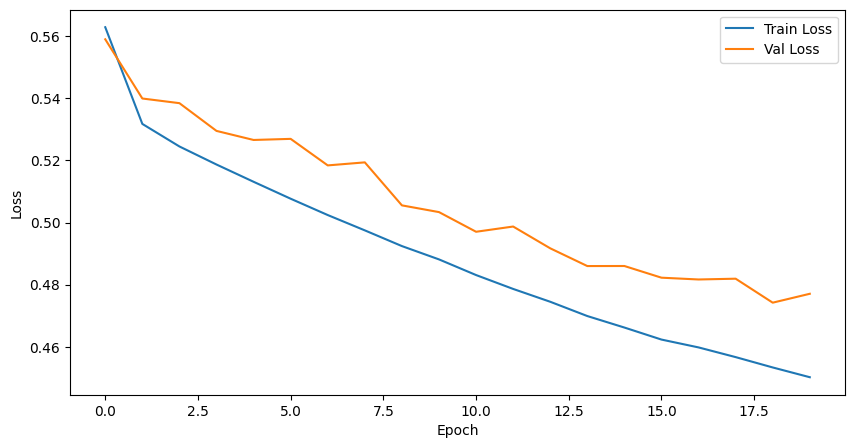

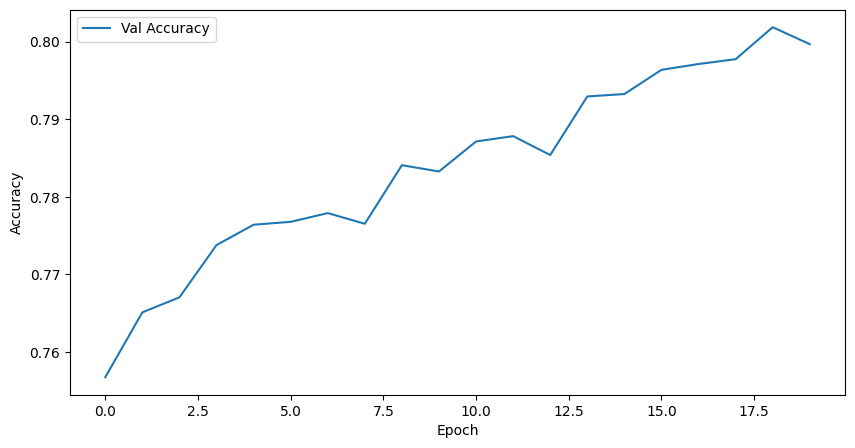

In [65]:
plt.figure(figsize=(10, 5))  # Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10, 5))  # Plot Validation Accuracy
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 5: Tune Hyperparameters

## Expand Model Flexibility

In [68]:
class BasketballClassifier(nn.Module):
    '''Modify original classification model to have configurable activation function'''
    
    def __init__(self, input_size=features, hidden_sizes=[64, 32], num_classes=3, activation='relu'):
        super(BasketballClassifier, self).__init__()
        layers = []
        in_size = input_size
        activations = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(),
        }
        act = activations[activation.lower()]
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(act)
            in_size = h
        layers.append(nn.Linear(in_size, num_classes))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

## Define a Training Loop Function

In [70]:
def train_and_evaluate(hidden_sizes, lr, batch_size, activation, epochs=Tuning_EPOCHS):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model = BasketballClassifier(
        input_size=features,
        hidden_sizes=hidden_sizes,
        activation=activation
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        val_accuracies.append(acc)
    return val_accuracies[-1]

## Grid Search

In [72]:
param_grid = {
    'hidden_sizes': [[64], [128, 64], [256, 128, 64]],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [16, 32, 64],
    'activation': ['relu', 'leakyrelu']
}
param_combinations = list(product(
    param_grid['hidden_sizes'],
    param_grid['lr'],
    param_grid['batch_size'],
    param_grid['activation']
))

In [73]:
start = time.time()
grid_results = []
for i, (hidden_sizes, lr, batch_size, activation) in enumerate(param_combinations):
    acc = train_and_evaluate(
        hidden_sizes=hidden_sizes,
        lr=lr,
        batch_size=batch_size,
        activation=activation,
        epochs=Tuning_EPOCHS
    )
    grid_results.append({
        'hidden_sizes': hidden_sizes,
        'lr': lr,
        'batch_size': batch_size,
        'activation': activation,
        'val_acc': acc
    })
    if i % 10 == 0:
        print(f"\nTesting Config {i+1}/{len(param_combinations)}:")
    else:
        continue
end = time.time()
print(f"Elapsed time: {(end - start)/60:.2f} minutes")


Testing Config 1/54:

Testing Config 11/54:

Testing Config 21/54:

Testing Config 31/54:

Testing Config 41/54:

Testing Config 51/54:
Elapsed time: 36.55 minutes


In [74]:
best_params = max(grid_results, key=lambda x: x['val_acc'])
print("Best Parameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")

Best Parameters:
hidden_sizes: [256, 128, 64]
lr: 0.001
batch_size: 16
activation: leakyrelu
val_acc: 0.8398802843247287


# 6: Retrain Model

In [76]:
full_train_dataset = ConcatDataset([train_dataset, val_dataset])
best_config = {k: v for k, v in best_params.items() if k != 'val_acc'}
print(f"Best Parameters:\n{best_config}")
final_model = BasketballClassifier(
    input_size=features,
    hidden_sizes=best_config['hidden_sizes'],
    activation=best_config['activation']
).to(device)
final_optimizer = Adam(final_model.parameters(), lr=best_config['lr'])
final_criterion = nn.CrossEntropyLoss()
final_loader = DataLoader(full_train_dataset, batch_size=best_config['batch_size'], shuffle=True)

Best Parameters:
{'hidden_sizes': [256, 128, 64], 'lr': 0.001, 'batch_size': 16, 'activation': 'leakyrelu'}


In [77]:
start = time.time()
for epoch in range(EPOCHS):
    final_model.train()
    total_loss = 0
    for X_batch, y_batch in final_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        final_optimizer.zero_grad()
        output = final_model(X_batch)
        loss = final_criterion(output, y_batch)
        loss.backward()
        final_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(final_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Final Train Loss: {avg_loss:.4f}")
    print('='*50)
end = time.time()
print(f"Elapsed time: {(end - start):.2f} seconds")

Epoch 1/20 - Final Train Loss: 0.5505
Epoch 2/20 - Final Train Loss: 0.5155
Epoch 3/20 - Final Train Loss: 0.4865
Epoch 4/20 - Final Train Loss: 0.4577
Epoch 5/20 - Final Train Loss: 0.4325
Epoch 6/20 - Final Train Loss: 0.4128
Epoch 7/20 - Final Train Loss: 0.3934
Epoch 8/20 - Final Train Loss: 0.3802
Epoch 9/20 - Final Train Loss: 0.3673
Epoch 10/20 - Final Train Loss: 0.3542
Epoch 11/20 - Final Train Loss: 0.3441
Epoch 12/20 - Final Train Loss: 0.3339
Epoch 13/20 - Final Train Loss: 0.3230
Epoch 14/20 - Final Train Loss: 0.3165
Epoch 15/20 - Final Train Loss: 0.3084
Epoch 16/20 - Final Train Loss: 0.3010
Epoch 17/20 - Final Train Loss: 0.2957
Epoch 18/20 - Final Train Loss: 0.2886
Epoch 19/20 - Final Train Loss: 0.2823
Epoch 20/20 - Final Train Loss: 0.2769
Elapsed time: 177.76 seconds


# 7: Evaluate on Test Set

In [79]:
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'])
final_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = final_model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=encoder.classes_))

Test Accuracy: 0.8647671301203317

Classification Report:
               precision    recall  f1-score   support

           C       0.90      1.00      0.95      5391
           F       0.77      0.62      0.69      3727
           G       0.87      0.89      0.88      6921

    accuracy                           0.86     16039
   macro avg       0.85      0.84      0.84     16039
weighted avg       0.86      0.86      0.86     16039



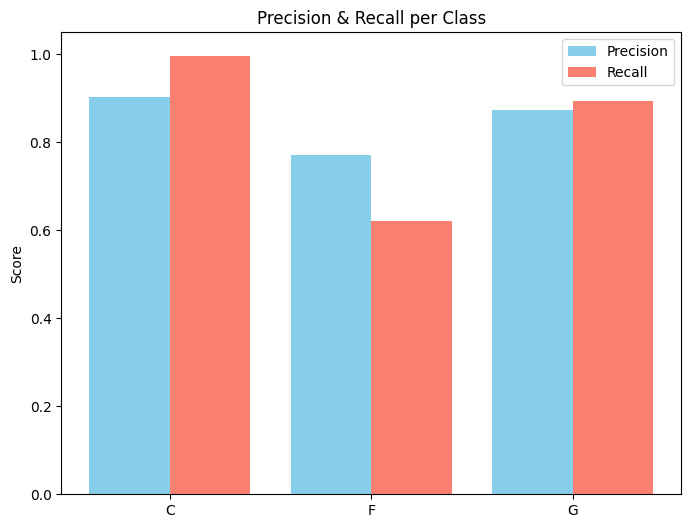

In [132]:
class_names = encoder.classes_
precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
x = np.arange(len(class_names))  # class indices
plt.figure(figsize=(8,6))
plt.bar(x-0.2, precision, width=0.4, label='Precision', color='skyblue')  # shift bar so no overlap
plt.bar(x+0.2, recall, width=0.4, label='Recall', color='salmon')  # shift bar so no overlap
plt.xticks(x, class_names)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Precision & Recall per Class")
plt.legend()
plt.show()